In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
import colormaps as cmaps
import os
import scipy as sp
from scipy.ndimage.interpolation import rotate
from magpie_data import PolarimetryMap2, FaradayMap2, NeLMap2, Interferogram, OpticalFrames
import scipy.constants as c
from mcerp import N, umath, Gamma
from bdots import *
import pickle
from matplotlib import rc
## for Palatino and other serif fonts use:
rc('font',**{'family':'serif','serif':['Palatino Linotype']})

# Chapter 2

## Faraday Analysis Example

In [2]:
cd "~\Google Drive\MAGPIE\data\2015\s0513_15 RECONNECTION - Carbon repeat\s0513_15"

C:\Users\jdhare\Google Drive\MAGPIE\data\2015\s0513_15 RECONNECTION - Carbon repeat\s0513_15


In [3]:
B0fn="13-May-2015 16_39_56_1355463638_fliplr.png"
B1fn="13-May-2015 16_39_56_2211629970.png"
S0fn="13-May-2015 17_00_09_1355463638_fliplr.png"
S1fn="13-May-2015 17_00_09_2211629970.png"
s0513_15_pol=PolarimetryMap2(B0fn, B1fn, B0fn, B1fn, S0fn, S1fn)
s=s0513_15_pol

In [8]:
s.register()

C:\Users\jdavies\Anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:549: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


In [16]:
s.pickle_transform('s0513_16 faraday registration.txt')

In [10]:
s.convert_to_alpha()

<IPython.core.display.Javascript object>


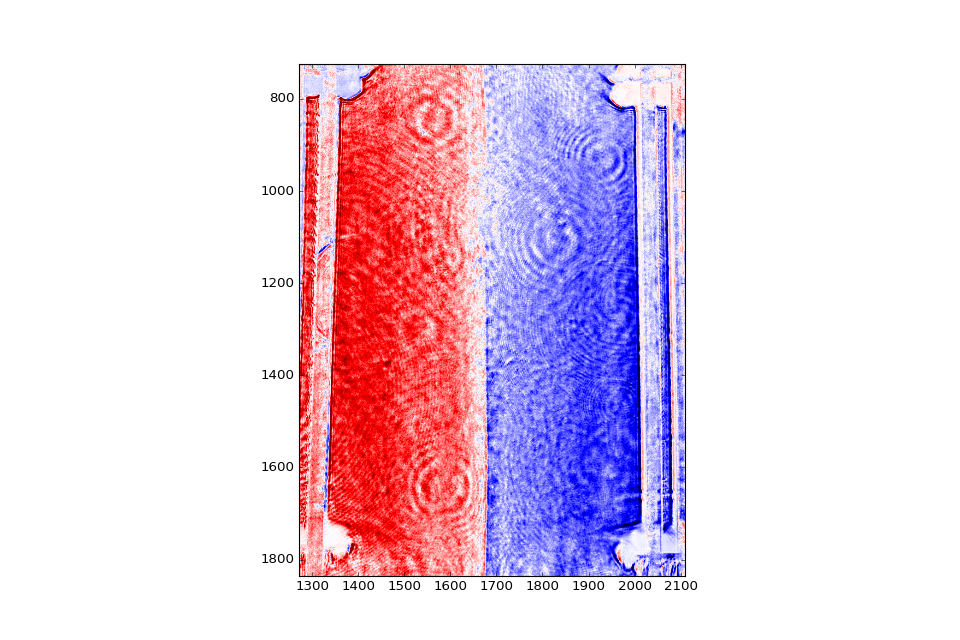

In [15]:
s.plot_data_px(clim=[-1,1])

<IPython.core.display.Javascript object>


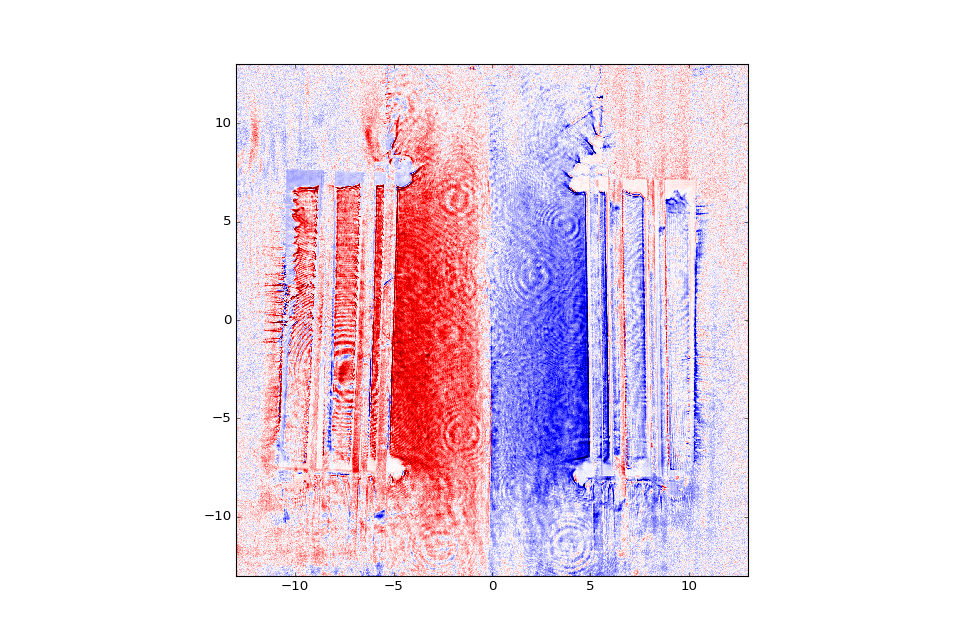

In [71]:
s.scale=67
s.set_origin([1255,1682], extent=[-13,13,-13,13])
s.plot_data_mm(clim=[-1,1])

In [145]:
cd "~\Google Drive\MAGPIE\data\2015\s0513_15 RECONNECTION - Carbon repeat"

C:\Users\jdavies\Google Drive\MAGPIE\data\2015\s0513_15 RECONNECTION - Carbon repeat


In [57]:
s0513_15_far=FaradayMap2(s0513_15_pol,"s0513_15 IR side on image registration flipud.jpg", "s0513_15 neL side on.txt")

In [137]:
f=s0513_15_far
f.register(constraints={'angle':(0,0.1),'scale':(0.7,0.1),'ty':(0,400),'tx':(40,400)})

C:\Users\jdavies\Anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:549: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\jdavies\Documents\magpie-analysis\magpie_data.py:194: RuntimeWarning: divide by zero encountered in true_divide
  self.data=5.99e18*self.pm.data/self.I1T
C:\Users\jdavies\Documents\magpie-analysis\magpie_data.py:194: RuntimeWarning: overflow encountered in true_divide
  self.data=5.99e18*self.pm.data/self.I1T
C:\Users\jdavies\Documents\magpie-analysis\magpie_data.py:194: RuntimeWarning: invalid value encountered in true_divide
  self.data=5.99e18*self.pm.data/self.I1T


<IPython.core.display.Javascript object>


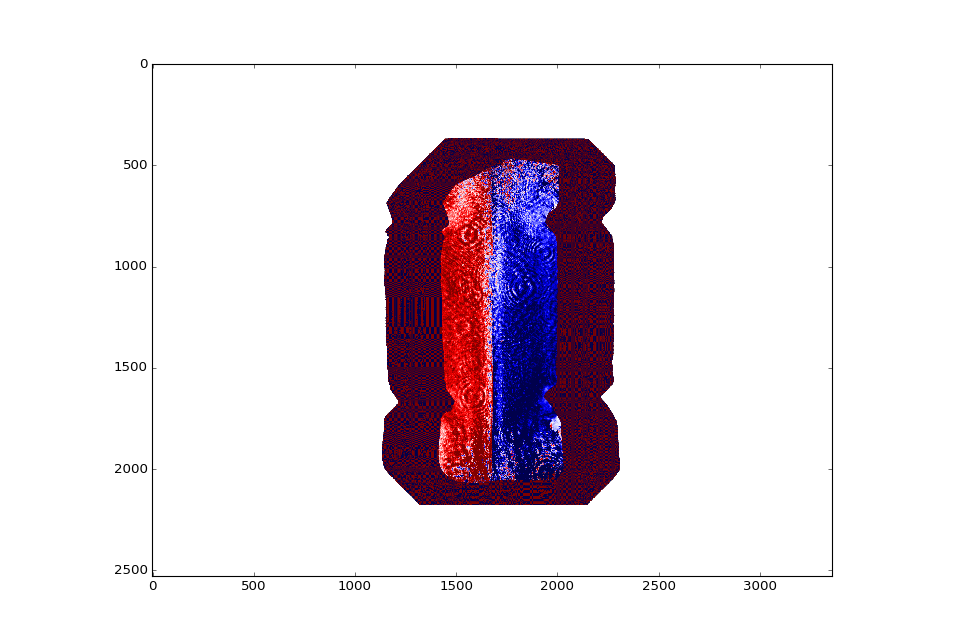

In [138]:
f.plot_data_px(clim=[-3,3])

In [68]:
f.transform

{'angle': -0.0004517333136675461,
 'scale': 0.71287100417764904,
 'tvec': array([ 10.08143623,  28.92796871])}

<IPython.core.display.Javascript object>


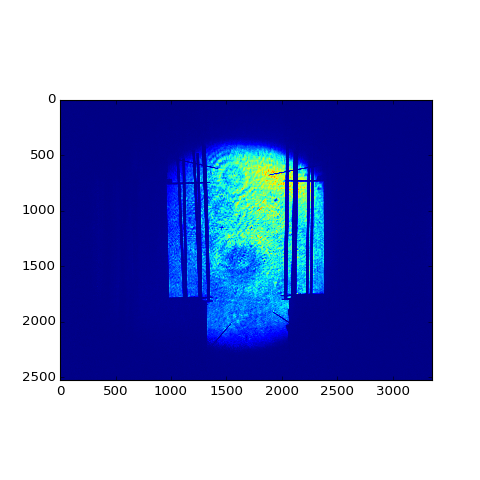

In [67]:
fig,ax=plt.subplots(figsize=(6,6))
ax.imshow(np.flipud(f.pm.B0))

In [72]:
f.scale=s.scale
f.set_origin(s.origin, extent=[-13,13,-13,13])

<IPython.core.display.Javascript object>


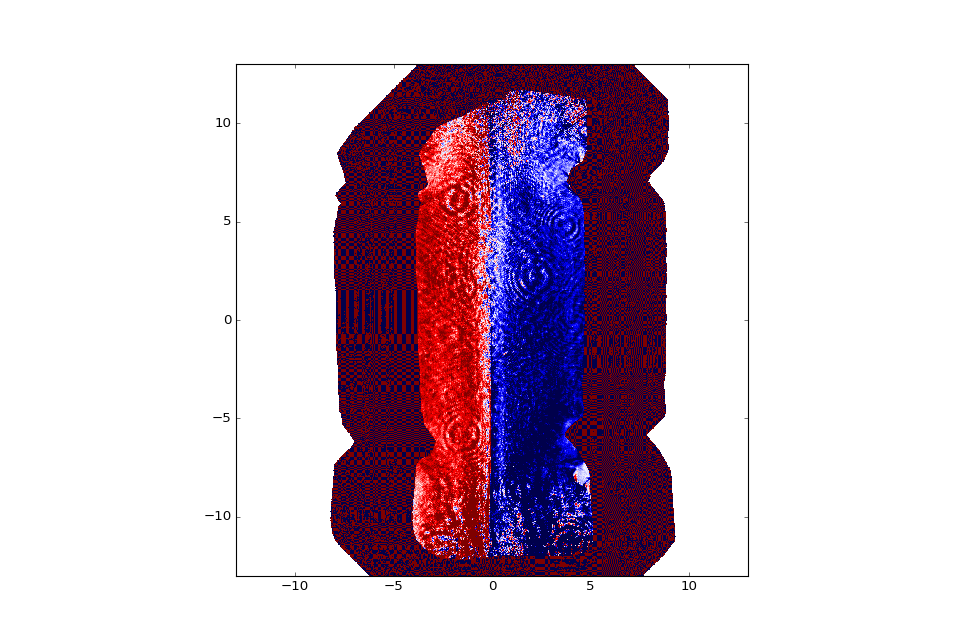

In [73]:
f.plot_data_mm(clim=[-3,3])

In [78]:
cd "C:\Users\jdavies\Google Drive\MAGPIE\thesis\images\chapter2 embedded images"

C:\Users\jdavies\Google Drive\MAGPIE\thesis\images\chapter2 embedded images


In [143]:
fig.savefig('s0513_16 Bfield.png', dpi=300, bbox_inches='tight')

# Thomson Convolution

In [2]:
from spectral_density_functions import *
from lmfit.models import VoigtModel

In [3]:
T_e=70
T_i=70
Z=6
n_e=5e18
A=12
theta=45

lambda_in=532e-9
lambda_range=np.linspace(531e-9,533e-9,1000)

skw=S_k_omega(lambda_range, lambda_in, theta, A, T_e,T_i,n_e,Z)

vm=VoigtModel()#Borrow a Voigt profile from the lmfit package to use as our response function
#Response centered on l0, width 0.16 Angstrom as experimentally measured. 
#To view the unconvolved spectrum, I suggest reducing sigma to 1e-13.
response=vm.eval(x=lambda_range, center=lambda_in,gamma=1.41e-11, sigma=1.27e-11,amplitude=1.0)

skw_conv=S_k_omega_conv(lambda_range, lambda_in, response, theta, A, T_e,T_i,n_e,Z)

shift=(lambda_range-lambda_in)*10**10#angstroms

<IPython.core.display.Javascript object>


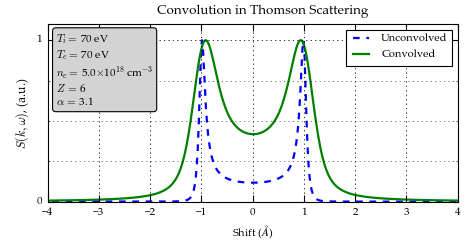

In [5]:
fig, ax=plt.subplots(figsize=(5.96,3))
ax.plot(shift, skw, lw=2, c='blue', ls='--', label='Unconvolved')
ax.plot(shift, skw_conv, lw=2, c='green', label='Convolved')

a=ax
a.tick_params(labelsize=10, pad=5, length=6, width=1)
a.grid(True)
a.set_xlabel(r"Shift ($\AA$)", fontsize=10)
a.xaxis.set_minor_locator(MultipleLocator(1))
a.yaxis.set_minor_locator(MultipleLocator(0.25))

a.grid(which='minor')
a.set_ylim([0,1.1])
a.set_yticks([0,1])
a.set_ylabel(r'$S(k,\omega)$, (a.u.)', fontsize=11)

a.set_xlim([-4,4])
#a.set_xticks([0,100,200,300,400])

ax.legend(fontsize=10)



fig.subplots_adjust(left=0.1, bottom=0.16, right=0.96, top=0.9,
                wspace=0.3, hspace=0.1)

fig.suptitle(r"Convolution in Thomson Scattering", fontsize=12, x=0.55)

#Quickly calculate alpha for the info-box
l0=lambda_in
lambda_De=7.43*(T_e/n_e)**0.5 #in m
th=theta
k=2.0**1.5*np.pi/l0*(1-np.cos(th))**0.5
alpha=np.abs(1/(k*lambda_De))
#makes strings from all the paramters for the info-box
ti = r'$T_i=\,$'+str(T_i)+' eV'
te = r'$T_e=\,$'+str(T_e)+' eV'
ne = r'$n_e=\,$'+str(n_e/1e18)+r'$\times$10$^{18}$ cm$^{-3}$'
alp = r'$\alpha\,=\,$'+str(round_to_n(alpha, 2))
textstr= (ti+'\n'+te+'\n'
          +ne+'\n'
          +'$Z\,=\,$'+str(Z)+'\n'
          +alp)
# these are matplotlib.patch.Patch properties for the info-box
props = dict(boxstyle='round', facecolor='lightgray')
# place an info box in upper left in axes coords
ax.text(0.02, 0.96, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)



In [6]:
th_folder=r'~\Google Drive\MAGPIE\thesis\images'
fn='chapter2_thomson_convolution.pdf'
p=os.path.expanduser(os.path.join(th_folder,fn))
fig.savefig(p, dpi=400)

In [7]:
'''
This useful function is for integrating over an aperture, where theta and phi change
but not any of the other plasma parameters.
'''
skw_th_ph=lambda th, ph: S_k_omega_emag3D(l,lambda_in=l0, theta=th, theta_0=theta_0, phi=ph,
                                       A=A,Z=Z,
                                       T_e=T_e,T_i=T_i,n_e=n_e, v_fe=v_fe, v_fi=v_fi,
                                       B=B, theta_B=thB, phi_B=phB, n_har=n_har)

In [8]:
l=np.linspace(6940,6946,2000)*1e-10#generate an array of wavelengths in nm
l0=6943e-10#central wavelength
vm=VoigtModel()#Borrow a Voigt profile from the lmfit package to use as our response function
#Response centered on l0, width 0.16 Angstrom as experimentally measured. 
#To view the unconvolved spectrum, I suggest reducing sigma to 1e-13.
resp=vm.eval(x=l, center=l0,gamma=1.41e-13, sigma=1.27e-12,amplitude=1.0)

'''Plasma Parameters'''
n_e=2e15#cm^-3
A=1#Ion mass
Z=1#Ion charge
T_i=20#in eV
T_e=20#in eV
v_fe=0#in ms^-1. Don't change this
v_fi=0#in ms^-1. Don't change this

'''Scattering angle'''
theta_0=30#in degrees, angle between k_in and k_s

'''Aperture'''
theta_A=0.85#aperture half opening angle in degrees
steps=11 #number of integration steps. Time taken to computer scales as the square. Try 11.

'''Magnetic Field'''
B=1.4 #field strength in Tesla
thB=90#pi/2-theta_B-theta/2, set theta_B=pi/2 here for maximum effect
phB=90 #out of plane angle for magnetic field
n_har=10#harmonics to calculate

#This is the unmagnetised S(k,w), convolved
skw=S_k_omega_conv(l, response=resp,lambda_in=l0, theta=theta_0,A=A,T_e=T_e,T_i=T_i,n_e=n_e,Z=Z, v_fe=v_fe, v_fi=v_fi)
skw_mag=aperture_integ_and_convolve(skw_th_ph, theta_A, steps, resp)

<IPython.core.display.Javascript object>


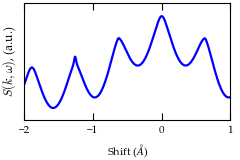

In [9]:
shift=(l-l0)*1e10

fig, ax=plt.subplots(figsize=(3,2))
ax.plot(shift, skw_mag, lw=2, c='blue', label='Convolved')

a=ax
a.tick_params(labelsize=10, pad=5, length=6, width=1)
a.set_xlabel(r"Shift ($\AA$)", fontsize=10)
a.set_ylim([0.6,1.05])
a.set_yticks([])
a.set_ylabel(r'$S(k,\omega)$, (a.u.)', fontsize=11)

a.set_xlim([-2,1])
a.set_xticks([-2,-1,0,1])


fig.subplots_adjust(left=0.1, bottom=0.25, right=0.96, top=0.98,
                wspace=0.3, hspace=0.1)

#fig.suptitle(r"Synthetic Magnetised Thomson Scattering Spectrum", fontsize=12, x=0.55)

#Quickly calculate alpha for the info-box
lambda_De=7.43*(T_e/n_e)**0.5 #in m
th=theta_0
k=2.0**1.5*np.pi/l0*(1-np.cos(th))**0.5
alpha=np.abs(1/(k*lambda_De))
#makes strings from all the paramters for the info-box
ti = r'$T_i=\,$'+str(T_i)+' eV'
te = r'$T_e=\,$'+str(T_e)+' eV'
ne = r'$n_e=\,$'+str(n_e/1e15)+r'$\times$10$^{15}$ cm$^{-3}$'
alp = r'$\alpha\,=\,$'+str(round_to_n(alpha, 2))
textstr= (ti+'\n'+te+'\n'
          +ne+'\n'
          +'$Z\,=\,$'+str(Z)+'\n'
          +alp)
# these are matplotlib.patch.Patch properties for the info-box
props = dict(boxstyle='round', facecolor='lightgray')
# place an info box in upper left in axes coords
#ax.text(0.02, 0.96, textstr, transform=ax.transAxes, fontsize=10,verticalalignment='top', bbox=props)

In [10]:
th_folder=r'~\Google Drive\MAGPIE\thesis\images\chapter2 embedded images'
fn='chapter2_synthetic_magnetised_thomson.pdf'
p=os.path.expanduser(os.path.join(th_folder,fn))
fig.savefig(p, dpi=400)

# Chapter 4

### I(t) figure

<IPython.core.display.Javascript object>


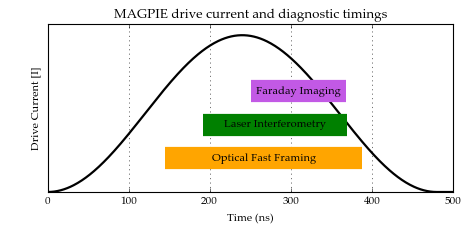

In [11]:
t=np.linspace(0, 500, 500)
I_0=1.4
tau=240
I=I_0*np.sin(np.pi*t/(2*tau))**2
I[2*tau:]=0

fig, ax=plt.subplots(figsize=(5.96,3),frameon = False)
ax.plot(t, I, lw=2, c='k')

b=145
e=388
h=0.3
ax.plot([b, e],[h,h], lw=20, c='orange',solid_capstyle='butt')
ax.text((b+e)/2, h, s='Optical Fast Framing', va='center', ha='center',fontsize=10)

b=192
e=369
h=0.6
ax.plot([b, e],[h,h], lw=20, c='green',solid_capstyle='butt')
ax.text((b+e)/2, h, s='Laser Interferometry', va='center', ha='center',fontsize=10)

b=251
e=368
h=0.9
ax.plot([b, e],[h,h], lw=20, c='#c259e5',solid_capstyle='butt')
ax.text((b+e)/2, h, s='Faraday Imaging', va='center', ha='center',fontsize=10)



ax.set_ylim([0,1.5])
ax.set_yticks([])
ax.tick_params(labelsize=10)
ax.set_xlabel('Time (ns)', fontsize=10)
ax.set_ylabel(r'Drive Current [I]', fontsize=10)
ax.set_title('MAGPIE drive current and diagnostic timings', fontsize=12)
ax.grid(True)
ax.set_axisbelow(True)

plt.subplots_adjust(left=0.1, bottom=0.2, right=0.95, top=0.9,
                wspace=0.1, hspace=0.15)


In [12]:
th_folder=r'~\Google Drive\MAGPIE\thesis\images'
fn='chapter4_current_diagnostics.pdf'
p=os.path.expanduser(os.path.join(th_folder,fn))
fig.savefig(p, dpi=600)

# 12 Frame Images

In [13]:
from magpie_data import OpticalFrames

## s1214_15

In [14]:
cd "~\Google Drive\MAGPIE\data\2015\s1214_15 C Reconnection 12 Frame\s1214_15\s1214_15 shifted

C:\Users\jdhare\Google Drive\MAGPIE\data\2015\s1214_15 C Reconnection 12 Frame\s1214_15\s1214_15 shifted


In [15]:
s1214_15=OpticalFrames(168,20)
s=s1214_15
s.logarithm()
s.rotate(-90+56)
#s.plot_rot(frame=2)
s.crop((512,608), xcrop=230, ycrop=300)
#s.plot_crop()

<IPython.core.display.Javascript object>


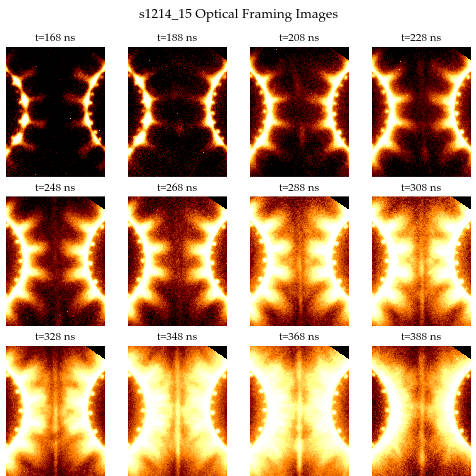

In [16]:
#151.3 mm = 5.96 inches

fig, ax=plt.subplots(3,4, figsize=(5.96,5.96),frameon = False)
plt.subplots_adjust(left=0, bottom=0, right=1, top=0.9,
                wspace=0.1, hspace=0.15)

for i in range(3):
    for j in range(4):
        fin=4*i+j
        ax[i,j].imshow(s.s_c[fin], cmap='afmhot', clim=[0.0,0.8], interpolation='none')
        ax[i,j].axis('off')
        ax[i,j].set_title('t='+str(s.frame_times[fin])+' ns', fontsize=10)
        
fig.suptitle(s.shot+' Optical Framing Images', fontsize=12)
#fig.tight_layout()

In [17]:
th_folder=r'~\Google Drive\MAGPIE\thesis\images'
fn='chapter4_'+s.shot+'_12frame.pdf'
p=os.path.expanduser(os.path.join(th_folder,fn))
fig.savefig(p, dpi=600)

## s0120B16

In [18]:
cd "~\Google Drive\MAGPIE\data\2016\s0120B16 C RECONNECTION 12 FRAME\s0120B16"

C:\Users\jdhare\Google Drive\MAGPIE\data\2016\s0120B16 C RECONNECTION 12 FRAME\s0120B16


In [19]:
s0120B16=OpticalFrames(188,15)
s=s0120B16
s.logarithm()
s.rotate(-90+25)
#s.plot_rot(frame=2)
s.crop((634,597), xcrop=230, ycrop=300)
#s.plot_crop()

<IPython.core.display.Javascript object>


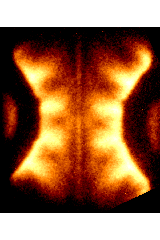

In [20]:
s.crop((634,597), xcrop=300, ycrop=350)

fig, ax=plt.subplots(figsize=(2,3),frameon = False)
ax.imshow(s.s_c[6], cmap='afmhot', clim=[0.2,1.0], interpolation='none')
ax.axis('off')
plt.subplots_adjust(left=0, bottom=0, right=1, top=1,
                wspace=0, hspace=0)
th_folder=r'~\Google Drive\MAGPIE\thesis\images\chapter 4 embedded images'
fn='chapter4_'+s.shot+'_single_frame.png'
p=os.path.expanduser(os.path.join(th_folder,fn))
fig.savefig(p, dpi=600)

<IPython.core.display.Javascript object>


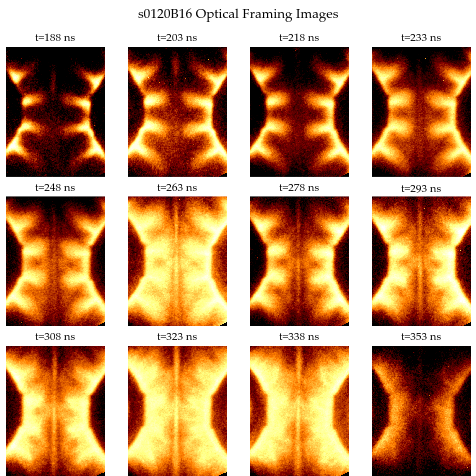

In [21]:
#151.3 mm = 5.96 inches
s.crop((634,597), xcrop=230, ycrop=300)

fig, ax=plt.subplots(3,4, figsize=(5.96,5.96),frameon = False)
plt.subplots_adjust(left=0, bottom=0, right=1, top=0.9,
                wspace=0.1, hspace=0.15)

for i in range(3):
    for j in range(4):
        fin=4*i+j
        ax[i,j].imshow(s.s_c[fin], cmap='afmhot', clim=[0.2,1.0], interpolation='none')
        ax[i,j].axis('off')
        ax[i,j].set_title('t='+str(s.frame_times[fin])+' ns', fontsize=10)
        
fig.suptitle(s.shot+' Optical Framing Images', fontsize=12)
#fig.tight_layout()

In [22]:
th_folder=r'~\Google Drive\MAGPIE\thesis\images'
fn='chapter4_'+s.shot+'_12frame.pdf'
p=os.path.expanduser(os.path.join(th_folder,fn))
fig.savefig(p, dpi=600)

## s0120_16

In [23]:
cd "~\Google Drive\MAGPIE\data\2016\s0120_16 C RECONNECTION 12 FRAME\s0120_16"

C:\Users\jdhare\Google Drive\MAGPIE\data\2016\s0120_16 C RECONNECTION 12 FRAME\s0120_16


In [24]:
s0120_16=OpticalFrames(145,15)
s=s0120_16
s.logarithm()
s.rotate(-90+22.5)
s.crop((614,563), xcrop=230, ycrop=300)

<IPython.core.display.Javascript object>


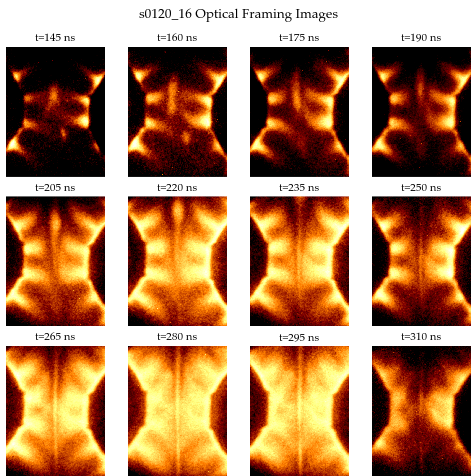

In [25]:
#151.3 mm = 5.96 inches

fig, ax=plt.subplots(3,4, figsize=(5.96,5.96),frameon = False)
plt.subplots_adjust(left=0, bottom=0, right=1, top=0.9,
                wspace=0.1, hspace=0.15)

for i in range(3):
    for j in range(4):
        fin=4*i+j
        ax[i,j].imshow(s.s_c[fin], cmap='afmhot', clim=[0.2,1.0], interpolation='none')
        ax[i,j].axis('off')
        ax[i,j].set_title('t='+str(s.frame_times[fin])+' ns', fontsize=10)
        
fig.suptitle(s.shot+' Optical Framing Images', fontsize=12)

In [26]:
th_folder=r'~\Google Drive\MAGPIE\thesis\images'
fn='chapter4_'+s.shot+'_12frame.pdf'
p=os.path.expanduser(os.path.join(th_folder,fn))
fig.savefig(p, dpi=600)

## 12 frame comparisons

<IPython.core.display.Javascript object>


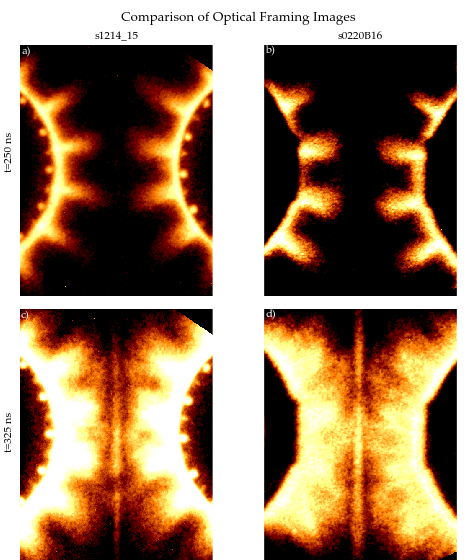

In [27]:
fig, ax=plt.subplots(2,2, figsize=(5.96,7),frameon = False)
plt.subplots_adjust(left=0, bottom=0, right=1, top=0.92,
                wspace=0.05, hspace=0.05)
ax[0,0].imshow(s1214_15.s_c[4], cmap='afmhot', clim=[0.2,1.0], interpolation='none')
ax[0,1].imshow(s0120B16.s_c[4], cmap='afmhot', clim=[0.6,0.9], interpolation='none')

ax[1,0].imshow(s1214_15.s_c[8], cmap='afmhot', clim=[0.2,0.7], interpolation='none')
ax[1,1].imshow(s0120B16.s_c[9], cmap='afmhot', clim=[0.5,0.9], interpolation='none')

ax[0,0].set_title('s1214_15', fontsize=10)
ax[0,1].set_title('s0220B16', fontsize=10)

fig.text(x=0.01, y=0.75, rotation='vertical', s='t=250 ns', fontsize=10)
fig.text(x=0.01, y=0.25, rotation='vertical', s='t=325 ns', fontsize=10)

for a in ax.flatten():
    a.axis('off')
    
for a, t in zip(ax.flatten(), ['a)', 'b)', 'c)', 'd)']):
    a.text(x=2, y=15, s=t, color='white', fontsize=10, va='center')
        
fig.suptitle('Comparison of Optical Framing Images', fontsize=12)


In [28]:
th_folder=r'~\Google Drive\MAGPIE\thesis\images'
fn='chapter4_12frame_comparisons.pdf'
p=os.path.expanduser(os.path.join(th_folder,fn))
fig.savefig(p, dpi=600)

<IPython.core.display.Javascript object>


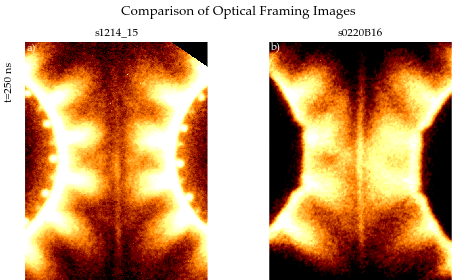

In [29]:
fig, ax=plt.subplots(1,2, figsize=(5.96,3.5),frameon = False)
plt.subplots_adjust(left=0, bottom=0, right=1, top=0.85,
                wspace=0.05, hspace=0.05)
ax[0].imshow(s1214_15.s_c[6], cmap='afmhot', clim=[0.1,0.8], interpolation='none')
ax[1].imshow(s0120_16.s_c[8], cmap='afmhot', clim=[0.4,0.9], interpolation='none')

ax[0].set_title('s1214_15', fontsize=10)
ax[1].set_title('s0220B16', fontsize=10)

fig.text(x=0.01, y=0.75, rotation='vertical', s='t=250 ns', fontsize=10)

for a in ax.flatten():
    a.axis('off')
    
for a, t in zip(ax.flatten(), ['a)', 'b)', 'c)', 'd)']):
    a.text(x=2, y=15, s=t, color='white', fontsize=10, va='center')
        
fig.suptitle('Comparison of Optical Framing Images', fontsize=12)


# Interferometry
w, h=151.3, 235 mm = 5.96, 9.25 inches

## s0119_16 (NOT USED)

In [2]:
cd "C:\Users\jdavies\Google Drive\MAGPIE\data\2016\s0119_16 C RECONNECTION 12 FRAME"

C:\Users\jdavies\Google Drive\MAGPIE\data\2016\s0119_16 C RECONNECTION 12 FRAME


In [3]:
rot=-90-20
s0119_16_532=NeLMap2('s0119_16 532nm neL.txt', scale=173, rot_angle=rot, multiply_by=1/1.6)
s=s0119_16_532
title='s0119_16, t=171ns'
s.data=s.data-3e17
s.set_origin(origin=[2906,2182], extent=[-11.5,11.5,-8,8])

In [4]:
i=Interferogram('s0119_16 532nm end on interferometry (4).JPG', rot_angle=rot, scale=s.scale)
i.set_origin(origin=s.origin, extent=[-11.5,11.5,-8,8])

<IPython.core.display.Javascript object>


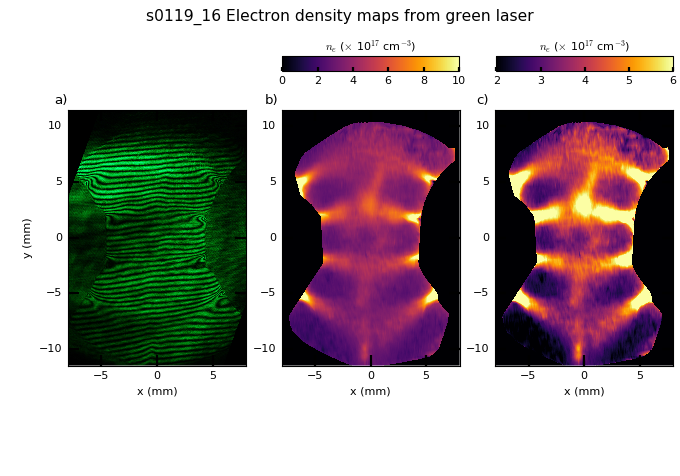

In [72]:
fig, ax=plt.subplots(1,3, figsize=(8.5,5.96))

# raw interferogram

i.plot_data_mm(ax=ax[0])

#large dynamic range electron density map
ne1=s.plot_data_mm(clim=[0,10], multiply_by=1e-17, ax=ax[1])

#set up the colourbar
cbar_ax1 = fig.add_axes([0.415, 0.85, 0.26, 0.03])#l,b,w,h
fig.colorbar(ne1, cax=cbar_ax1, ticks=[0,2,4,6,8,10], orientation='horizontal')

#large dynamic range electron density map
ne2=s.plot_data_mm(clim=[2,6], multiply_by=1e-17, ax=ax[2])

#set up the colourbar
cbar_ax2 = fig.add_axes([0.73, 0.85, 0.26, 0.03])#l,b,w,h
fig.colorbar(ne2, cax=cbar_ax2, ticks=[2,3,4,5,6], orientation='horizontal')

#tweak the plots subtly.
fig.subplots_adjust(left=0.1, bottom=0, right=0.99, top=1,
                wspace=0.2, hspace=0)

#title and subfigure labels.
fig.suptitle(s.fn+' Electron density maps from green laser', fontsize=14)

fig.text(s='a)', x=0.08, y=0.78, fontsize=12)
fig.text(s='b)', x=0.39, y=0.78, fontsize=12)
fig.text(s='c)', x=0.7, y=0.78, fontsize=12)

#labels and ticks
for a in ax:
    a.set_xlabel('x (mm)',fontsize=10)
    a.set_xticks([-5,0,5])
    a.tick_params(labelsize=10, pad=5, length=10, width=2)
ax[0].set_ylabel('y (mm)',fontsize=10)

#colour bars
for c in [cbar_ax1, cbar_ax2]:
    c.set_xlabel(r'$n_e$ ($\times$ 10$^{17}$ cm$^{-3}$)',fontsize=10)
    c.xaxis.set_label_position('top')
    c.tick_params(labelsize=10, pad=5, length=4, width=2)

In [74]:
th_folder=r'~\Google Drive\MAGPIE\thesis\images'
fn='chapter4_'+s.fn+'_532nm.png'
p=os.path.expanduser(os.path.join(th_folder,fn))
fig.savefig(p, dpi=400)

## s0612_15

In [175]:
%cd "~\Google Drive\MAGPIE\data\2015\s0612_15 RECONNECTION C TS"

rot=-90
s0612_15_532=NeLMap2('s0612_15 532nm neL.txt', scale=173, rot_angle=rot, multiply_by=1/1.6)
s=s0612_15_532
s.set_origin(origin=(2430,1450), extent=[-11.5,11.5,-8,8])

C:\Users\jdhare\Documents\GitHub\magpie-analysis\magpie_data.py:36: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.data_c=self.data[ymin:ymax, xmin:xmax]


In [71]:
i=Interferogram('s0612_15 532nm end on interferometry (2).JPG', rot_angle=rot, scale=s.scale)
i.set_origin(origin=s.origin, extent=[-11.5,11.5,-8,8])

C:\Users\jdhare\Documents\GitHub\magpie-analysis\magpie_data.py:36: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.data_c=self.data[ymin:ymax, xmin:xmax]


In [ ]:
fig, ax=plt.subplots(1,3, figsize=(9.25,5.2))

# raw interferogram

i.plot_data_mm(ax=ax[0])

#large dynamic range electron density map
ne1=s.plot_data_mm(clim=[0,10], multiply_by=1e-17, ax=ax[1])

#set up the colourbar
cbar_ax1 = fig.add_axes([0.415, 0.1, 0.26, 0.03])#l,b,w,h
fig.colorbar(ne1, cax=cbar_ax1, ticks=[0,2,4,6,8,10], orientation='horizontal')

#large dynamic range electron density map
ne2=s.plot_data_mm(clim=[2,4], multiply_by=1e-17, ax=ax[2])

#set up the colourbar
cbar_ax2 = fig.add_axes([0.73, 0.1, 0.26, 0.03])#l,b,w,h
fig.colorbar(ne2, cax=cbar_ax2, ticks=[2,3,4], orientation='horizontal')

#tweak the plots subtly.
fig.subplots_adjust(left=0.1, bottom=0.1, right=0.99, top=1,
                wspace=0.2, hspace=0)

#title and subfigure labels.
fig.suptitle(s.fn+': Electron density map at t=192 ns', fontsize=14)

fig.text(s='a)', x=0.08, y=0.9, fontsize=12)
fig.text(s='b)', x=0.39, y=0.9, fontsize=12)
fig.text(s='c)', x=0.71, y=0.9, fontsize=12)

#labels and ticks
for a in ax:
    a.set_xlabel('x (mm)',fontsize=10)
    a.set_xticks([-5,0,5])
    a.tick_params(labelsize=10, pad=5, length=10, width=2)
ax[0].set_ylabel('y (mm)',fontsize=10)
ax[0].set_title('Raw Interferogram', fontsize=12)
ax[1].set_title('Overview density map', fontsize=12)
ax[2].set_title('Detailed density map', fontsize=12)

fig.text(s='Laser wavelength: 532 nm', x=0.12, y=0.1, fontsize=12)


#colour bars
for c in [cbar_ax1, cbar_ax2]:
    c.set_xlabel(r'$n_e$ ($\times$ 10$^{17}$ cm$^{-3}$)',fontsize=10)
    #c.xaxis.set_label_position('top')
    c.tick_params(labelsize=10, pad=5, length=4, width=1)
    #c.xaxis.tick_top()

<IPython.core.display.Javascript object>


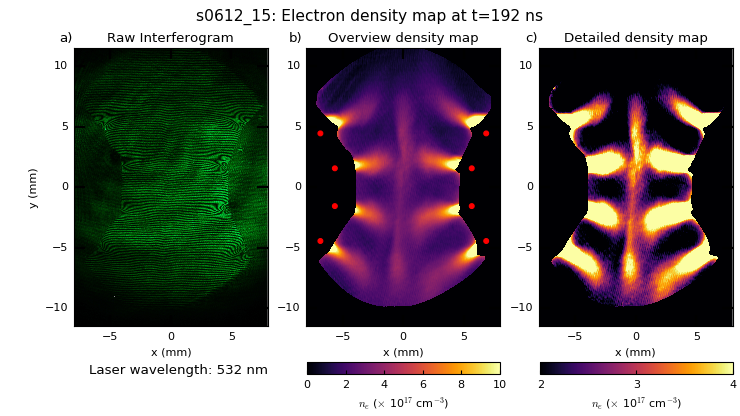

In [80]:
fig, ax=plt.subplots(1,3, figsize=(9.25,5.2))

# raw interferogram

i.plot_data_mm(ax=ax[0])

#large dynamic range electron density map
ne1=s.plot_data_mm(clim=[0,10], multiply_by=1e-17, ax=ax[1])

#set up the colourbar
cbar_ax1 = fig.add_axes([0.415, 0.1, 0.26, 0.03])#l,b,w,h
fig.colorbar(ne1, cax=cbar_ax1, ticks=[0,2,4,6,8,10], orientation='horizontal')

#large dynamic range electron density map
ne2=s.plot_data_mm(clim=[2,4], multiply_by=1e-17, ax=ax[2])

#set up the colourbar
cbar_ax2 = fig.add_axes([0.73, 0.1, 0.26, 0.03])#l,b,w,h
fig.colorbar(ne2, cax=cbar_ax2, ticks=[2,3,4], orientation='horizontal')

#tweak the plots subtly.
fig.subplots_adjust(left=0.1, bottom=0.1, right=0.99, top=1,
                wspace=0.2, hspace=0)

#title and subfigure labels.
fig.suptitle(s.fn+': Electron density map at t=192 ns', fontsize=14)

fig.text(s='a)', x=0.08, y=0.9, fontsize=12)
fig.text(s='b)', x=0.39, y=0.9, fontsize=12)
fig.text(s='c)', x=0.71, y=0.9, fontsize=12)

#labels and ticks
for a in ax:
    a.set_xlabel('x (mm)',fontsize=10)
    a.set_xticks([-5,0,5])
    a.tick_params(labelsize=10, pad=5, length=10, width=2)
ax[0].set_ylabel('y (mm)',fontsize=10)
ax[0].set_title('Raw Interferogram', fontsize=12)
ax[1].set_title('Overview density map', fontsize=12)
ax[2].set_title('Detailed density map', fontsize=12)

fig.text(s='Laser wavelength: 532 nm', x=0.12, y=0.1, fontsize=12)


#colour bars
for c in [cbar_ax1, cbar_ax2]:
    c.set_xlabel(r'$n_e$ ($\times$ 10$^{17}$ cm$^{-3}$)',fontsize=10)
    #c.xaxis.set_label_position('top')
    c.tick_params(labelsize=10, pad=5, length=4, width=1)
    #c.xaxis.tick_top()

th=np.linspace(-360/32*3,360/32*3,4)
for t in th:
    c= plt.Circle((-13.5+8*np.cos(t*np.pi/180),8*np.sin(t*np.pi/180)), 0.2, color='r')
    ax[1].add_artist(c)
    c= plt.Circle((13.5-8*np.cos(t*np.pi/180),8*np.sin(t*np.pi/180)), 0.2, color='r')
    ax[1].add_artist(c)


In [81]:
th_folder=r'~\Google Drive\MAGPIE\thesis\images'
fn='chapter4_'+s.fn+'_532nm.png'
p=os.path.expanduser(os.path.join(th_folder,fn))
fig.savefig(p, dpi=400)

## s1006_15 532 nm

In [30]:
%cd "~\Google Drive\MAGPIE\data\2015\s1006_15 Reconnection C TS upstream flow"

rot=-90
s1006_15_532=NeLMap2('s1006_15 532nm neL.txt', scale=173, rot_angle=rot, multiply_by=1/1.6)
s=s1006_15_532
s.set_origin(origin=(2305,1411), extent=[-11.5,11.5,-8,8])

C:\Users\jdhare\Google Drive\MAGPIE\data\2015\s1006_15 Reconnection C TS upstream flow


C:\Users\jdhare\Documents\GitHub\magpie-analysis\magpie_data.py:36: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.data_c=self.data[ymin:ymax, xmin:xmax]


In [31]:
i=Interferogram('s1006_15 532nm end on interferometry (2).JPG', rot_angle=rot, scale=s.scale)
i.set_origin(origin=s.origin, extent=[-11.5,11.5,-8,8])

C:\Users\jdhare\Documents\GitHub\magpie-analysis\magpie_data.py:36: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.data_c=self.data[ymin:ymax, xmin:xmax]


<IPython.core.display.Javascript object>


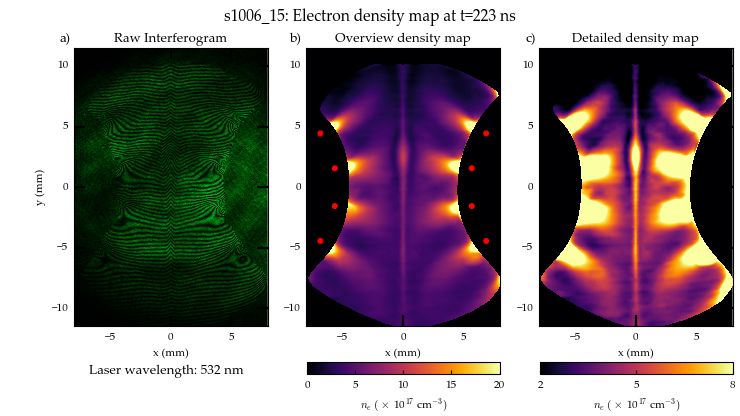

In [33]:
fig, ax=plt.subplots(1,3, figsize=(9.25,5.2))

# raw interferogram

i.plot_data_mm(ax=ax[0])

#large dynamic range electron density map
ne1=s.plot_data_mm(clim=[0,20], multiply_by=1e-17, ax=ax[1])

#set up the colourbar
cbar_ax1 = fig.add_axes([0.415, 0.1, 0.26, 0.03])#l,b,w,h
fig.colorbar(ne1, cax=cbar_ax1, ticks=[0,5,10,15,20], orientation='horizontal')

#large dynamic range electron density map
ne2=s.plot_data_mm(clim=[2,8], multiply_by=1e-17, ax=ax[2])

#set up the colourbar
cbar_ax2 = fig.add_axes([0.73, 0.1, 0.26, 0.03])#l,b,w,h
fig.colorbar(ne2, cax=cbar_ax2, ticks=[2,5,8], orientation='horizontal')

#tweak the plots subtly.
fig.subplots_adjust(left=0.1, bottom=0.1, right=0.99, top=1,
                wspace=0.2, hspace=0)

#title and subfigure labels.
fig.suptitle(s.fn+': Electron density map at t=223 ns', fontsize=14)

fig.text(s='a)', x=0.08, y=0.9, fontsize=12)
fig.text(s='b)', x=0.39, y=0.9, fontsize=12)
fig.text(s='c)', x=0.71, y=0.9, fontsize=12)

#labels and ticks
for a in ax:
    a.set_xlabel('x (mm)',fontsize=10)
    a.set_xticks([-5,0,5])
    a.tick_params(labelsize=10, pad=5, length=10, width=2)
ax[0].set_ylabel('y (mm)',fontsize=10)
ax[0].set_title('Raw Interferogram', fontsize=12)
ax[1].set_title('Overview density map', fontsize=12)
ax[2].set_title('Detailed density map', fontsize=12)

fig.text(s='Laser wavelength: 532 nm', x=0.12, y=0.1, fontsize=12)


#colour bars
for c in [cbar_ax1, cbar_ax2]:
    c.set_xlabel(r'$n_e$ $(\times$ 10$^{17}$ cm$^{-3})$',fontsize=10)
    #c.xaxis.set_label_position('top')
    c.tick_params(labelsize=10, pad=5, length=4, width=1)
    #c.xaxis.tick_top()
    
th=np.linspace(-360/32*3,360/32*3,4)
for t in th:
    c= plt.Circle((-13.5+8*np.cos(t*np.pi/180),8*np.sin(t*np.pi/180)), 0.2, color='r')
    ax[1].add_artist(c)
    c= plt.Circle((13.5-8*np.cos(t*np.pi/180),8*np.sin(t*np.pi/180)), 0.2, color='r')
    ax[1].add_artist(c)


In [34]:
th_folder=r'~\Google Drive\MAGPIE\thesis\images'
fn='chapter4_'+s.fn+'_532nm.png'
p=os.path.expanduser(os.path.join(th_folder,fn))
fig.savefig(p, dpi=400)

## s1006_15 355 nm

In [35]:
cd "~\Google Drive\MAGPIE\data\2015\s1006_15 Reconnection C TS upstream flow"

C:\Users\jdhare\Google Drive\MAGPIE\data\2015\s1006_15 Reconnection C TS upstream flow


In [36]:
rot=-90
s1006_15_355=NeLMap2('s1006_15 355nm neL itilt.txt', scale=128, rot_angle=rot, multiply_by=1/1.6, flip_lr=True)
s=s1006_15_355
s.set_origin(origin=(1618,1110), extent=[-11.5,11.5,-8,8])

C:\Users\jdhare\Documents\GitHub\magpie-analysis\magpie_data.py:36: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.data_c=self.data[ymin:ymax, xmin:xmax]


In [37]:
i=Interferogram('s1006_15 355 nm end on interferometry (2).JPG', rot_angle=rot, scale=s.scale, flip_lr=True)
i.set_origin(origin=s.origin, extent=[-11.5,11.5,-8,8])

C:\Users\jdhare\Documents\GitHub\magpie-analysis\magpie_data.py:36: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.data_c=self.data[ymin:ymax, xmin:xmax]


<IPython.core.display.Javascript object>


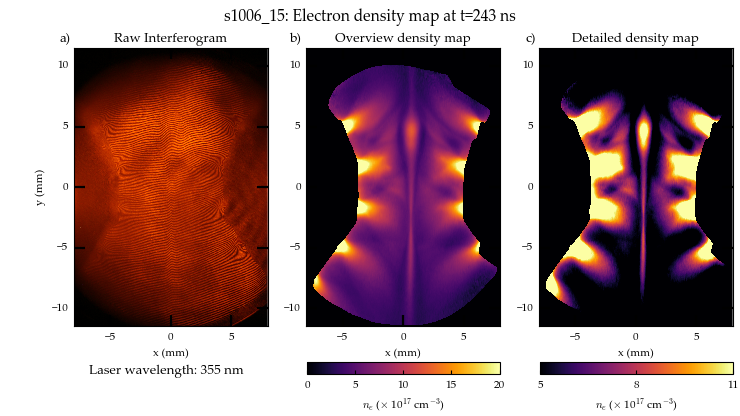

In [38]:
fig, ax=plt.subplots(1,3, figsize=(9.25,5.2))

# raw interferogram

i.plot_data_mm(ax=ax[0])

#large dynamic range electron density map
ne1=s.plot_data_mm(clim=[0,20], multiply_by=1e-17, ax=ax[1])

#set up the colourbar
cbar_ax1 = fig.add_axes([0.415, 0.1, 0.26, 0.03])#l,b,w,h
fig.colorbar(ne1, cax=cbar_ax1, ticks=[0,5,10,15,20], orientation='horizontal')

#large dynamic range electron density map
ne2=s.plot_data_mm(clim=[5,11], multiply_by=1e-17, ax=ax[2])

#set up the colourbar
cbar_ax2 = fig.add_axes([0.73, 0.1, 0.26, 0.03])#l,b,w,h
fig.colorbar(ne2, cax=cbar_ax2, ticks=[5,8,11], orientation='horizontal')

#tweak the plots subtly.
fig.subplots_adjust(left=0.1, bottom=0.1, right=0.99, top=1,
                wspace=0.2, hspace=0)

#title and subfigure labels.
fig.suptitle(s.fn+': Electron density map at t=243 ns', fontsize=14)

fig.text(s='a)', x=0.08, y=0.9, fontsize=12)
fig.text(s='b)', x=0.39, y=0.9, fontsize=12)
fig.text(s='c)', x=0.71, y=0.9, fontsize=12)

#labels and ticks
for a in ax:
    a.set_xlabel('x (mm)',fontsize=10)
    a.set_xticks([-5,0,5])
    a.tick_params(labelsize=10, pad=5, length=10, width=2)
ax[0].set_ylabel('y (mm)',fontsize=10)
ax[0].set_title('Raw Interferogram', fontsize=12)
ax[1].set_title('Overview density map', fontsize=12)
ax[2].set_title('Detailed density map', fontsize=12)

fig.text(s='Laser wavelength: 355 nm', x=0.12, y=0.1, fontsize=12)


#colour bars
for c in [cbar_ax1, cbar_ax2]:
    c.set_xlabel(r'$n_e$ ($\times$ 10$^{17}$ cm$^{-3}$)',fontsize=10)
    #c.xaxis.set_label_position('top')
    c.tick_params(labelsize=10, pad=5, length=4, width=1)
    #c.xaxis.tick_top()

In [39]:
th_folder=r'~\Google Drive\MAGPIE\thesis\images'
fn='chapter4_'+s.fn+'_355nm.png'
p=os.path.expanduser(os.path.join(th_folder,fn))
fig.savefig(p, dpi=400)

## s1026_15 532 nm

In [9]:
%cd "~\Google Drive\MAGPIE\data\2015\s1026_15 Reconnection C TS Outflow 255ns"

s1026_15_532=NeLMap2('s1026_15 532nm neL.txt', scale=173, rot_angle=-90, multiply_by=1/1.6)
s1026_15_532.set_origin(origin=(2377,1438), extent=[-11.5,11.5,-8,8])
s=s1026_15_532

C:\Users\jdhare\Documents\GitHub\magpie-analysis\magpie_data.py:36: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.data_c=self.data[ymin:ymax, xmin:xmax]


In [ ]:
i=Interferogram('s1026_15 532nm end on interferometry (1).JPG', rot_angle=-90, scale=s.scale)
i.set_origin(origin=s.origin, extent=[-11.5,11.5,-8,8])

In [ ]:
fig, ax=plt.subplots(1,3, figsize=(9.25,5.2))

# raw interferogram

i.plot_data_mm(ax=ax[0])

#large dynamic range electron density map
ne1=s.plot_data_mm(clim=[0,20], multiply_by=1e-17, ax=ax[1])

#set up the colourbar
cbar_ax1 = fig.add_axes([0.415, 0.1, 0.26, 0.03])#l,b,w,h
fig.colorbar(ne1, cax=cbar_ax1, ticks=[0,5,10,15,20], orientation='horizontal')

#large dynamic range electron density map
ne2=s.plot_data_mm(clim=[4,10], multiply_by=1e-17, ax=ax[2])

#set up the colourbar
cbar_ax2 = fig.add_axes([0.73, 0.1, 0.26, 0.03])#l,b,w,h
fig.colorbar(ne2, cax=cbar_ax2, ticks=[4,6,8,10], orientation='horizontal')

#tweak the plots subtly.
fig.subplots_adjust(left=0.1, bottom=0.1, right=0.99, top=1,
                wspace=0.2, hspace=0)

#title and subfigure labels.
fig.suptitle(s.fn+': Electron density map at t=272 ns', fontsize=14)

fig.text(s='a)', x=0.08, y=0.9, fontsize=12)
fig.text(s='b)', x=0.39, y=0.9, fontsize=12)
fig.text(s='c)', x=0.71, y=0.9, fontsize=12)

#labels and ticks
for a in ax:
    a.set_xlabel('x (mm)',fontsize=10)
    a.set_xticks([-5,0,5])
    a.tick_params(labelsize=10, pad=5, length=10, width=2)
ax[0].set_ylabel('y (mm)',fontsize=10)
ax[0].set_title('Raw Interferogram', fontsize=12)
ax[1].set_title('Overview density map', fontsize=12)
ax[2].set_title('Detailed density map', fontsize=12)

fig.text(s='Laser wavelength: 532 nm', x=0.12, y=0.1, fontsize=12)


#colour bars
for c in [cbar_ax1, cbar_ax2]:
    c.set_xlabel(r'$n_e$ ($\times$ 10$^{17}$ cm$^{-3}$)',fontsize=10)
    #c.xaxis.set_label_position('top')
    c.tick_params(labelsize=10, pad=5, length=4, width=1)
    #c.xaxis.tick_top()

In [ ]:
th_folder=r'~\Google Drive\MAGPIE\thesis\images'
fn='chapter4_'+s.fn+'_532nm.png'
p=os.path.expanduser(os.path.join(th_folder,fn))
fig.savefig(p, dpi=400)

## s1026_15 355 nm

In [10]:
cd "~\Google Drive\MAGPIE\data\2015\s1026_15 Reconnection C TS Outflow 255ns"

C:\Users\jdhare\Google Drive\MAGPIE\data\2015\s1026_15 Reconnection C TS Outflow 255ns


In [11]:
s1026_15_355=NeLMap2('s1026_15 355nm neL.txt', scale=128, multiply_by=2/1.6, rot_angle=-90, flip_lr=True)
s1026_15_355.set_origin(origin=(1540,1110), extent=[-11.5,11.5,-8,8])
s=s1026_15_355

C:\Users\jdhare\Documents\GitHub\magpie-analysis\magpie_data.py:36: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.data_c=self.data[ymin:ymax, xmin:xmax]


In [ ]:
i=Interferogram('s1026_15 355 nm end on interferoemtry (2).JPG', rot_angle=-90, scale=s.scale, flip_lr=True)
i.set_origin(origin=s.origin, extent=[-11.5,11.5,-8,8])

In [ ]:
fig, ax=plt.subplots(1,3, figsize=(9.25,5.2))

# raw interferogram

i.plot_data_mm(ax=ax[0])

#large dynamic range electron density map
ne1=s.plot_data_mm(clim=[0,20], multiply_by=1e-17, ax=ax[1])

#set up the colourbar
cbar_ax1 = fig.add_axes([0.415, 0.1, 0.26, 0.03])#l,b,w,h
fig.colorbar(ne1, cax=cbar_ax1, ticks=[0,5,10,15,20], orientation='horizontal')

#large dynamic range electron density map
ne2=s.plot_data_mm(clim=[4,10], multiply_by=1e-17, ax=ax[2])

#set up the colourbar
cbar_ax2 = fig.add_axes([0.73, 0.1, 0.26, 0.03])#l,b,w,h
fig.colorbar(ne2, cax=cbar_ax2, ticks=[4,6,8,10], orientation='horizontal')

#tweak the plots subtly.
fig.subplots_adjust(left=0.1, bottom=0.1, right=0.99, top=1,
                wspace=0.2, hspace=0)

#title and subfigure labels.
fig.suptitle(s.fn+': Electron density map at t=292 ns', fontsize=14)

fig.text(s='a)', x=0.08, y=0.9, fontsize=12)
fig.text(s='b)', x=0.39, y=0.9, fontsize=12)
fig.text(s='c)', x=0.71, y=0.9, fontsize=12)

#labels and ticks
for a in ax:
    a.set_xlabel('x (mm)',fontsize=10)
    a.set_xticks([-5,0,5])
    a.tick_params(labelsize=10, pad=5, length=10, width=2)
ax[0].set_ylabel('y (mm)',fontsize=10)
ax[0].set_title('Raw Interferogram', fontsize=12)
ax[1].set_title('Overview density map', fontsize=12)
ax[2].set_title('Detailed density map', fontsize=12)

fig.text(s='Laser wavelength: 355 nm', x=0.12, y=0.1, fontsize=12)


#colour bars
for c in [cbar_ax1, cbar_ax2]:
    c.set_xlabel(r'$n_e$ ($\times$ 10$^{17}$ cm$^{-3}$)',fontsize=10)
    #c.xaxis.set_label_position('top')
    c.tick_params(labelsize=10, pad=5, length=4, width=1)
    #c.xaxis.tick_top()

In [ ]:
th_folder=r'~\Google Drive\MAGPIE\thesis\images'
fn='chapter4_'+s.fn+'_355nm.png'
p=os.path.expanduser(os.path.join(th_folder,fn))
fig.savefig(p, dpi=400)

## s0429_16 532nm

In [13]:
%cd "~\Google Drive\MAGPIE\data\2016\s0429_16 C Reconnection TS"

s0429_16_532=NeLMap2('s0429_16 532nm neL.txt', scale=168, multiply_by=1/1.6, rot_angle=-90+22.5)
s=s0429_16_532
s.set_origin(origin=(2850,2348), extent=[-11.5,11.5,-8,8])

C:\Users\jdhare\Documents\GitHub\magpie-analysis\magpie_data.py:36: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.data_c=self.data[ymin:ymax, xmin:xmax]


In [ ]:
i=Interferogram('s0429_16 532nm end on interferometry (1).JPG', rot_angle=-90+22.5, scale=s.scale)
i.set_origin(origin=s.origin, extent=[-11.5,11.5,-8,8])

In [ ]:
fig, ax=plt.subplots(1,3, figsize=(9.25,5.2))

# raw interferogram

i.plot_data_mm(ax=ax[0])

#large dynamic range electron density map
ne1=s.plot_data_mm(clim=[0,15], multiply_by=1e-17, ax=ax[1])

#set up the colourbar
cbar_ax1 = fig.add_axes([0.415, 0.1, 0.26, 0.03])#l,b,w,h
fig.colorbar(ne1, cax=cbar_ax1, ticks=[0,5,10,15], orientation='horizontal')

#large dynamic range electron density map
ne2=s.plot_data_mm(clim=[4,8], multiply_by=1e-17, ax=ax[2])

#set up the colourbar
cbar_ax2 = fig.add_axes([0.73, 0.1, 0.26, 0.03])#l,b,w,h
fig.colorbar(ne2, cax=cbar_ax2, ticks=[4,6,8], orientation='horizontal')

#tweak the plots subtly.
fig.subplots_adjust(left=0.1, bottom=0.1, right=0.99, top=1,
                wspace=0.2, hspace=0)

#title and subfigure labels.
fig.suptitle(s.fn+': Electron density map at t=327 ns', fontsize=14)

fig.text(s='a)', x=0.08, y=0.9, fontsize=12)
fig.text(s='b)', x=0.39, y=0.9, fontsize=12)
fig.text(s='c)', x=0.71, y=0.9, fontsize=12)

#labels and ticks
for a in ax:
    a.set_xlabel('x (mm)',fontsize=10)
    a.set_xticks([-5,0,5])
    a.tick_params(labelsize=10, pad=5, length=10, width=2)
ax[0].set_ylabel('y (mm)',fontsize=10)
ax[0].set_title('Raw Interferogram', fontsize=12)
ax[1].set_title('Overview density map', fontsize=12)
ax[2].set_title('Detailed density map', fontsize=12)

fig.text(s='Laser wavelength: 532 nm', x=0.12, y=0.1, fontsize=12)


#colour bars
for c in [cbar_ax1, cbar_ax2]:
    c.set_xlabel(r'$n_e$ ($\times$ 10$^{17}$ cm$^{-3}$)',fontsize=10)
    c.tick_params(labelsize=10, pad=5, length=4, width=1)    

In [ ]:
th_folder=r'~\Google Drive\MAGPIE\thesis\images'
fn='chapter4_'+s.fn+'_532nm.png'
p=os.path.expanduser(os.path.join(th_folder,fn))
fig.savefig(p, dpi=400)

## s0429_16 355 nm

In [15]:
%cd "~\Google Drive\MAGPIE\data\2016\s0429_16 C Reconnection TS"

s0429_16_355=NeLMap2('s0429_16 355nm neL.txt', scale=168, multiply_by=1/1.6, rot_angle=-90+22.5, flip_lr=True)
s=s0429_16_355
s.set_origin(origin=(2711,2268), extent=[-11.5,11.5,-8,8])

C:\Users\jdhare\Documents\GitHub\magpie-analysis\magpie_data.py:36: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.data_c=self.data[ymin:ymax, xmin:xmax]


In [ ]:
i=Interferogram('s0429_16 355nm end on interferometry (1).JPG', rot_angle=-90+22.5, scale=s.scale, flip_lr=True)
i.set_origin(origin=s.origin, extent=[-11.5,11.5,-8,8])

In [ ]:
fig, ax=plt.subplots(1,3, figsize=(9.25,5.2))

# raw interferogram

i.plot_data_mm(ax=ax[0])

#large dynamic range electron density map
ne1=s.plot_data_mm(clim=[0,15], multiply_by=1e-17, ax=ax[1])

#set up the colourbar
cbar_ax1 = fig.add_axes([0.415, 0.1, 0.26, 0.03])#l,b,w,h
fig.colorbar(ne1, cax=cbar_ax1, ticks=[0,5,10,15], orientation='horizontal')

#large dynamic range electron density map
ne2=s.plot_data_mm(clim=[4,8], multiply_by=1e-17, ax=ax[2])

#set up the colourbar
cbar_ax2 = fig.add_axes([0.73, 0.1, 0.26, 0.03])#l,b,w,h
fig.colorbar(ne2, cax=cbar_ax2, ticks=[4,6,8], orientation='horizontal')

#tweak the plots subtly.
fig.subplots_adjust(left=0.1, bottom=0.1, right=0.99, top=1,
                wspace=0.2, hspace=0)

#title and subfigure labels.
fig.suptitle(s.fn+': Electron density map at t=347 ns', fontsize=14)

fig.text(s='a)', x=0.08, y=0.9, fontsize=12)
fig.text(s='b)', x=0.39, y=0.9, fontsize=12)
fig.text(s='c)', x=0.71, y=0.9, fontsize=12)

#labels and ticks
for a in ax:
    a.set_xlabel('x (mm)',fontsize=10)
    a.set_xticks([-5,0,5])
    a.tick_params(labelsize=10, pad=5, length=10, width=2)
ax[0].set_ylabel('y (mm)',fontsize=10)
ax[0].set_title('Raw Interferogram', fontsize=12)
ax[1].set_title('Overview density map', fontsize=12)
ax[2].set_title('Detailed density map', fontsize=12)

fig.text(s='Laser wavelength: 355 nm', x=0.12, y=0.1, fontsize=12)


#colour bars
for c in [cbar_ax1, cbar_ax2]:
    c.set_xlabel(r'$n_e$ ($\times$ 10$^{17}$ cm$^{-3}$)',fontsize=10)
    c.tick_params(labelsize=10, pad=5, length=4, width=1)    

In [ ]:
th_folder=r'~\Google Drive\MAGPIE\thesis\images'
fn='chapter4_'+s.fn+'_355nm.png'
p=os.path.expanduser(os.path.join(th_folder,fn))
fig.savefig(p, dpi=400)

## s0830_16 532 nm

In [17]:
%cd "~\Google Drive\MAGPIE\data\2016\s0830_16 Reconnection C Faraday"

s0830_16_532=NeLMap2('s0830_16 532nm neL.txt', scale=173, rot_angle=-90+1.3, multiply_by=1/1.6)
s=s0830_16_532
s.set_origin(origin=(2250,1554),extent=[-11.5,11.5,-8,8])

C:\Users\jdhare\Documents\GitHub\magpie-analysis\magpie_data.py:36: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.data_c=self.data[ymin:ymax, xmin:xmax]


In [ ]:
i=Interferogram('s0830_16 532nm interferometry (2).JPG', rot_angle=-90+1.3, scale=s.scale)
i.set_origin(origin=s.origin, extent=[-11.5,11.5,-8,8])

In [ ]:
fig, ax=plt.subplots(1,3, figsize=(9.25,5.2))

# raw interferogram

i.plot_data_mm(ax=ax[0])

#large dynamic range electron density map
ne1=s.plot_data_mm(clim=[0,12], multiply_by=1e-17, ax=ax[1])

#set up the colourbar
cbar_ax1 = fig.add_axes([0.415, 0.1, 0.26, 0.03])#l,b,w,h
fig.colorbar(ne1, cax=cbar_ax1, ticks=[0,4,8,12], orientation='horizontal')

#large dynamic range electron density map
ne2=s.plot_data_mm(clim=[5,9], multiply_by=1e-17, ax=ax[2])

#set up the colourbar
cbar_ax2 = fig.add_axes([0.73, 0.1, 0.26, 0.03])#l,b,w,h
fig.colorbar(ne2, cax=cbar_ax2, ticks=[5,7,9], orientation='horizontal')

#tweak the plots subtly.
fig.subplots_adjust(left=0.1, bottom=0.1, right=0.99, top=1,
                wspace=0.2, hspace=0)

#title and subfigure labels.
fig.suptitle(s.fn+': Electron density map at t=369 ns', fontsize=14)

fig.text(s='a)', x=0.08, y=0.9, fontsize=12)
fig.text(s='b)', x=0.39, y=0.9, fontsize=12)
fig.text(s='c)', x=0.71, y=0.9, fontsize=12)

#labels and ticks
for a in ax:
    a.set_xlabel('x (mm)',fontsize=10)
    a.set_xticks([-5,0,5])
    a.tick_params(labelsize=10, pad=5, length=10, width=2)
ax[0].set_ylabel('y (mm)',fontsize=10)
ax[0].set_title('Raw Interferogram', fontsize=12)
ax[1].set_title('Overview density map', fontsize=12)
ax[2].set_title('Detailed density map', fontsize=12)

fig.text(s='Laser wavelength: 532 nm', x=0.12, y=0.1, fontsize=12)


#colour bars
for c in [cbar_ax1, cbar_ax2]:
    c.set_xlabel(r'$n_e$ ($\times$ 10$^{17}$ cm$^{-3}$)',fontsize=10)
    c.tick_params(labelsize=10, pad=5, length=4, width=1)    

In [ ]:
th_folder=r'~\Google Drive\MAGPIE\thesis\images'
fn='chapter4_'+s.fn+'_532nm.png'
p=os.path.expanduser(os.path.join(th_folder,fn))
fig.savefig(p, dpi=400)

## Interferometry Comparisons

In [2]:
%cd "~\Google Drive\MAGPIE\data\2015\s0612_15 RECONNECTION C TS"
rot=-90
s0612_15_532=NeLMap2('s0612_15 532nm neL.txt', scale=173, rot_angle=rot, multiply_by=1/1.6)
s=s0612_15_532
s.set_origin(origin=(2430,1450), extent=[-11.5,11.5,-8,8])

%cd "~\Google Drive\MAGPIE\data\2015\s1006_15 Reconnection C TS upstream flow"
rot=-90
s1006_15_532=NeLMap2('s1006_15 532nm neL.txt', scale=173, rot_angle=rot, multiply_by=1/1.6)
s=s1006_15_532
s.set_origin(origin=(2305,1411), extent=[-11.5,11.5,-8,8])

rot=-90
s1006_15_355=NeLMap2('s1006_15 355nm neL itilt.txt', scale=128, rot_angle=rot, multiply_by=1/1.6, flip_lr=True)
s=s1006_15_355
s.set_origin(origin=(1618,1110), extent=[-11.5,11.5,-8,8])

%cd "~\Google Drive\MAGPIE\data\2015\s1026_15 Reconnection C TS Outflow 255ns"

s1026_15_532=NeLMap2('s1026_15 532nm neL.txt', scale=173, rot_angle=-90, multiply_by=1/1.6)
s1026_15_532.set_origin(origin=(2377,1438), extent=[-11.5,11.5,-8,8])
s=s1026_15_532

s1026_15_355=NeLMap2('s1026_15 355nm neL.txt', scale=128, multiply_by=2/1.6, rot_angle=-90, flip_lr=True)
s1026_15_355.set_origin(origin=(1540,1110), extent=[-11.5,11.5,-8,8])
s=s1026_15_355

%cd "~\Google Drive\MAGPIE\data\2016\s0429_16 C Reconnection TS"

s0429_16_532=NeLMap2('s0429_16 532nm neL.txt', scale=168, multiply_by=1/1.6, rot_angle=-90+22.5)
s=s0429_16_532
s.set_origin(origin=(2850,2348), extent=[-11.5,11.5,-8,8])

s0429_16_355=NeLMap2('s0429_16 355nm neL.txt', scale=168, multiply_by=1/1.6, rot_angle=-90+22.5, flip_lr=True)
s=s0429_16_355
s.set_origin(origin=(2711,2268), extent=[-11.5,11.5,-8,8])

%cd "~\Google Drive\MAGPIE\data\2016\s0830_16 Reconnection C Faraday"

s0830_16_532=NeLMap2('s0830_16 532nm neL.txt', scale=173, rot_angle=-90+1.3, multiply_by=1/1.6)
s=s0830_16_532
s.set_origin(origin=(2250,1554),extent=[-11.5,11.5,-8,8])

C:\Users\jdhare\Google Drive\MAGPIE\data\2015\s0612_15 RECONNECTION C TS


C:\Users\jdhare\Documents\GitHub\magpie-analysis\magpie_data.py:36: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.data_c=self.data[ymin:ymax, xmin:xmax]


C:\Users\jdhare\Google Drive\MAGPIE\data\2015\s1006_15 Reconnection C TS upstream flow
C:\Users\jdhare\Google Drive\MAGPIE\data\2015\s1026_15 Reconnection C TS Outflow 255ns
C:\Users\jdhare\Google Drive\MAGPIE\data\2016\s0429_16 C Reconnection TS
C:\Users\jdhare\Google Drive\MAGPIE\data\2016\s0830_16 Reconnection C Faraday


In [370]:
%cd "~\Google Drive\MAGPIE\data\2015\s1006_15 Reconnection C TS upstream flow"

rot=-90
s1006_15_355=NeLMap2('s1006_15 355nm neL itilt.txt', scale=128, rot_angle=rot, multiply_by=1/1.6, flip_lr=True)
s=s1006_15_355
s.set_origin(origin=(1618,1110), extent=[-11.5,11.5,-8,8])

C:\Users\jdhare\Google Drive\MAGPIE\data\2015\s1006_15 Reconnection C TS upstream flow


C:\Users\jdhare\Documents\GitHub\magpie-analysis\magpie_data.py:36: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.data_c=self.data[ymin:ymax, xmin:xmax]


<IPython.core.display.Javascript object>


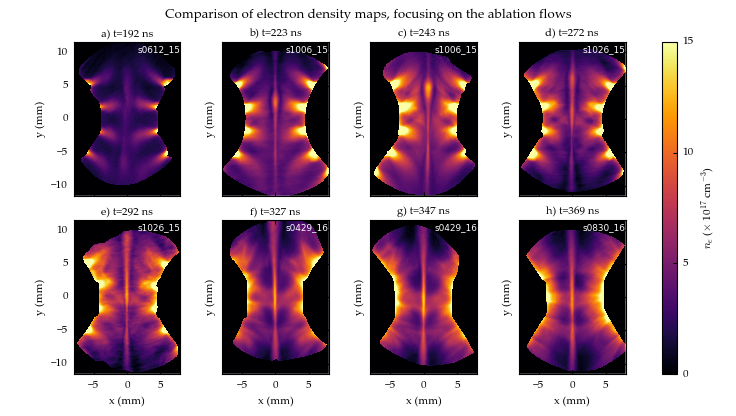

In [3]:
shots=[s0612_15_532, s1006_15_532, s1006_15_355, s1026_15_532, s1026_15_355, s0429_16_532, s0429_16_355, s0830_16_532]
t=[192,223,243,272,292,327,347,369]

import string
letters=list(string.ascii_lowercase)

fig, ax=plt.subplots(2,4, figsize=(9.2,5.2), sharey=True, sharex=True)

for i,s in enumerate(shots):
    j=1 if i>3 else 0
    a=ax.flatten()[i]
    ne=s.plot_data_mm(clim=[0,15], multiply_by=1e-17, ax=a)
    if i>3:
        a.set_xlabel('x (mm)', fontsize=10)
    if i is 0 or 4:
        a.set_ylabel('y (mm)', fontsize=10)
    a.set_xlim([-8,8])
    a.set_xticks([-5,0,5])
    a.set_title(letters[i]+') t='+str(t[i])+' ns', fontsize=10)
    a.tick_params(labelsize=10, pad=5, length=4, width=1)
    a.text(s=s.fn, x=8, y=10, color='white', fontsize=8, ha='right', fontname='Helvetica')

    
cbar_ax = fig.add_axes([0.9, 0.1, 0.02, 0.8])#l,b,w,h
fig.colorbar(ne, cax=cbar_ax, ticks=[0,5,10,15])
cbar_ax.set_ylabel(r'$n_e$ ($\times$ 10$^{17}$ cm$^{-3}$)',fontsize=10)
cbar_ax.tick_params(labelsize=10, pad=5, length=4, width=1)    

fig.suptitle('Comparison of electron density maps, focusing on the ablation flows',fontsize=12)    
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.85, top=0.9, wspace=0.39, hspace=0.15)


In [4]:
th_folder=r'~\Google Drive\MAGPIE\thesis\images'
fn='chapter4_interferometry_flows.png'
p=os.path.expanduser(os.path.join(th_folder,fn))
fig.savefig(p, dpi=400)

<IPython.core.display.Javascript object>


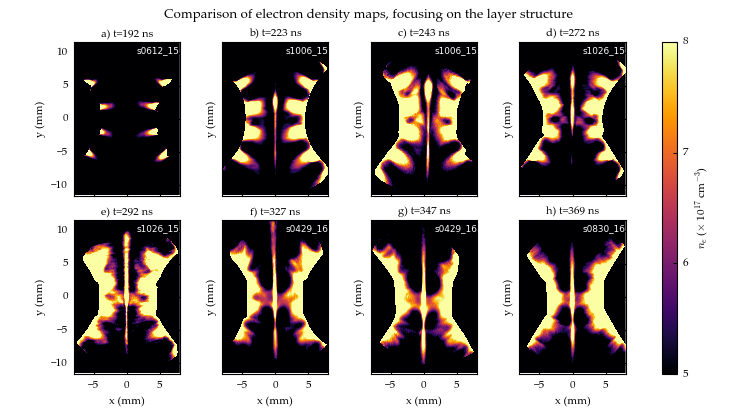

In [5]:
shots=[s0612_15_532, s1006_15_532, s1006_15_355, s1026_15_532, s1026_15_355, s0429_16_532, s0429_16_355, s0830_16_532]
t=[192,223,243,272,292,327,347,369]

import string
letters=list(string.ascii_lowercase)

fig, ax=plt.subplots(2,4, figsize=(9.2,5.2), sharey=True, sharex=True)

for i,s in enumerate(shots):
    j=1 if i>3 else 0
    a=ax.flatten()[i]
    ne=s.plot_data_mm(clim=[5,8], multiply_by=1e-17, ax=a)
    if i>3:
        a.set_xlabel('x (mm)', fontsize=10)
    if i is 0 or 4:
        a.set_ylabel('y (mm)', fontsize=10)
    a.set_xlim([-8,8])
    a.set_xticks([-5,0,5])
    a.set_title(letters[i]+') t='+str(t[i])+' ns', fontsize=10)
    a.tick_params(labelsize=10, pad=5, length=4, width=1)
    a.text(s=s.fn, x=8, y=10, color='white', fontsize=8, ha='right', fontname='Helvetica')

    
cbar_ax = fig.add_axes([0.9, 0.1, 0.02, 0.8])#l,b,w,h
fig.colorbar(ne, cax=cbar_ax, ticks=[5,6,7,8])
cbar_ax.set_ylabel(r'$n_e$ ($\times$ 10$^{17}$ cm$^{-3}$)',fontsize=10)
cbar_ax.tick_params(labelsize=10, pad=5, length=4, width=1)    

fig.suptitle('Comparison of electron density maps, focusing on the layer structure',fontsize=12)    
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.85, top=0.9, wspace=0.4, hspace=0.15)


In [6]:
th_folder=r'~\Google Drive\MAGPIE\thesis\images'
fn='chapter4_interferometry_layer.png'
p=os.path.expanduser(os.path.join(th_folder,fn))
fig.savefig(p, dpi=400)

## Central electron density

In [47]:
shots=[s0612_15_532, s1006_15_532, s1006_15_355, s1026_15_532, s1026_15_355, s0429_16_532, s0429_16_355, s0830_16_532]
n_e0=np.array([ss.data_c[ss.mm_to_px((0,0))] for ss in shots])
n_e1=np.array([ss.data_c[ss.mm_to_px((0,-1))] for ss in shots])

n_e0=[]
for ss in shots:
    ss.create_lineout(start=(1,0),end=(-1,0), lineout_width=ss.scale*0.1)
    n_e0.append(ss.lo.mean())

t=[192,223,243,272,292,327,347,369]

(1816, 1384) (2162, 1384)
(1816, 1384) (2162, 1384)
(1344, 1024) (1600, 1024)
(1816, 1384) (2162, 1384)
(1344, 1024) (1600, 1024)
(1764, 1344) (2100, 1344)
(1764, 1344) (2100, 1344)
(1816, 1384) (2162, 1384)


<IPython.core.display.Javascript object>


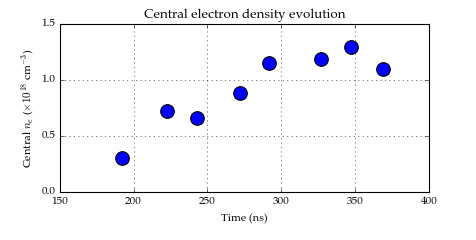

In [54]:
fig, ax=plt.subplots(figsize=(5.96, 3))
ax.scatter(t, np.array(n_e0)/1e18, s=150)
ax.set_ylim([0,1.5])
ax.set_yticks([0,0.5,1.0,1.5])
ax.tick_params(labelsize=10)
ax.set_xlabel('Time (ns)', fontsize=10)
ax.set_ylabel(r'Central $n_e$ ($\times 10^{18}$ cm$^{-3}$)', fontsize=10)
ax.set_title('Central electron density evolution', fontsize=12)
ax.grid(True)
plt.subplots_adjust(bottom=0.2)


In [55]:
th_folder=r'~\Google Drive\MAGPIE\thesis\images'
fn='chapter4_central_ne.pdf'
p=os.path.expanduser(os.path.join(th_folder,fn))
fig.savefig(p, dpi=400, bbox_inches='tight')

In [51]:
shots=[s0612_15_532, s1006_15_532, s1006_15_355, s1026_15_532, s1026_15_355, s0429_16_532, s0429_16_355, s0830_16_532]

n_el=[]
n_er=[]

for ss in shots:
    xx=2
    ss.create_lineout(start=(1,-xx),end=(-1,-xx), lineout_width=ss.scale*0.1)
    n_el.append(ss.lo.mean())
    ss.create_lineout(start=(1,xx),end=(-1,xx), lineout_width=ss.scale*0.1)
    n_er.append(ss.lo.mean())

t=[192,223,243,272,292,327,347,369]

(1816, 1038) (2162, 1038)
(1816, 1730) (2162, 1730)
(1816, 1038) (2162, 1038)
(1816, 1730) (2162, 1730)
(1344, 768) (1600, 768)
(1344, 1280) (1600, 1280)
(1816, 1038) (2162, 1038)
(1816, 1730) (2162, 1730)
(1344, 768) (1600, 768)
(1344, 1280) (1600, 1280)
(1764, 1008) (2100, 1008)
(1764, 1680) (2100, 1680)
(1764, 1008) (2100, 1008)
(1764, 1680) (2100, 1680)
(1816, 1038) (2162, 1038)
(1816, 1730) (2162, 1730)


<IPython.core.display.Javascript object>


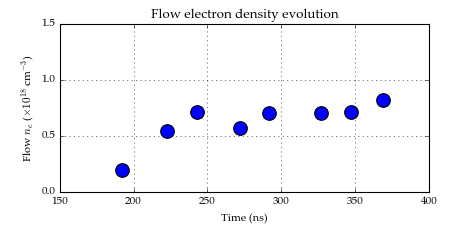

In [56]:
fig, ax=plt.subplots(figsize=(5.96, 3))
ax.scatter(t, (np.array(n_el)+np.array(n_er))/2e18, s=150)

ax.set_ylim([0,1.5])
ax.set_yticks([0,0.5,1.0,1.5])
ax.tick_params(labelsize=10)
ax.set_xlabel('Time (ns)', fontsize=10)
ax.set_ylabel(r'Flow $n_e$ ($\times 10^{18}$ cm$^{-3}$)', fontsize=10)
ax.set_title('Flow electron density evolution', fontsize=12)
ax.grid(True)
plt.subplots_adjust(bottom=0.2)


In [57]:
th_folder=r'~\Google Drive\MAGPIE\thesis\images'
fn='chapter4_flow_ne.pdf'
p=os.path.expanduser(os.path.join(th_folder,fn))
fig.savefig(p, dpi=400, bbox_inches='tight')

## MITL Bdots for timing

In [58]:
shots=['s0612_15', 's1006_15', 's1026_15', 's0429_16','s0830A16']
names=['s0612_15 532 nm', 's1006_15 532 nm', 's1006_15 355 nm', 's1026_15 532 nm', 's1026_15 355 nm', 's0429_16 532 nm', 's0429_16 355 nm', 's0830_16 532 nm']
m={}
for s in shots:
    m[s]=MitlBdots(s)

for bd in m['s1006_15'].mbds:
    bd.time=m['s0612_15'].mbds[0].time

<IPython.core.display.Javascript object>


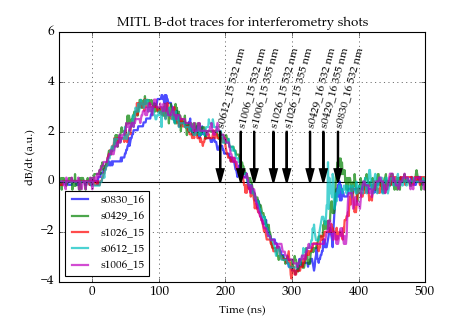

C:\Users\jdhare\Anaconda3\lib\site-packages\numpy\core\_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


In [65]:
fig, ax=plt.subplots(figsize=(15/2.54, 4))
i=2

ax.plot([-100,500], [0,0], c='k')
for mm in m:
    d=m[mm]
    d.truncate()
    if mm is 's0830A16':
        l='s0830_16'
    else:
        l=mm
    ax.plot(d.mbds[i].time_tr0-27, -d.mbds[i].data_tr, label=l, lw=2, alpha=0.7)
    
for tt,n in zip(t, names):
    ax.arrow(tt, 2, 0,-1.5, head_width=10, head_length=0.5, fc='k', ec='k',lw=2,zorder=10)
    ax.text(x=tt-5, y=2.1, s=str(n),rotation=75, va='bottom', ha='left', fontsize=10)
    
ax.set_xlim([-50,500])
ax.set_ylim([-4,6])
ax.legend(fontsize=10, loc=3)

ax.set_xlabel('Time (ns)', fontsize=10)
ax.set_ylabel('dB/dt (a.u.)', fontsize=10)
ax.set_title('MITL B-dot traces for interferometry shots', fontsize=12)
ax.grid(True)

plt.subplots_adjust(bottom=0.12)


In [66]:
th_folder=r'~\Google Drive\MAGPIE\thesis\images'
fn='chapter4_mitl_bdots.pdf'
p=os.path.expanduser(os.path.join(th_folder,fn))
fig.savefig(p, dpi=400)

# Chapter 5

## BDot pairs in Plasma

### s0125B16

### Bdots in divergent outflow

In [67]:
#T12 and T34 in divergent flow round the back., C12 and C34 in the reconnection outflow
shot="s0125B16"
pairs={"C12":"A", "C34":"B", "T12":"C", "T34":"D",}
attenuations={"A1":10.8,"A2":9.7,"B1":10, "B2":10.2, "C1":1, "C2":1, "D1":4, "D2":4}
diameters={"C12":2.0, "C34": 2.0, "T12":0.5, "T34":0.5} #diameter in mm
b=Bdots(shot=shot, pairs=pairs, attenuations=attenuations, diameters=diameters, threshold=1.0)
mb=MitlBdots(shot)

<IPython.core.display.Javascript object>


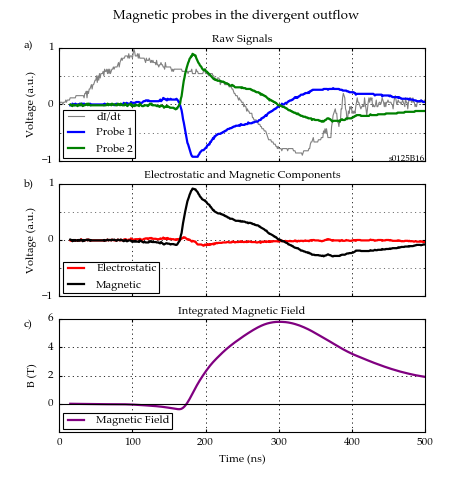

In [68]:
fig, ax=plt.subplots(3,1,figsize=(15/2.54, 6), sharex=True)

pair="T12"

a=ax[0]
a.plot(mb.mbds[2].time-1495, -mb.mbds[2].data/4, lw=1, label="dI/dt", c='grey')

a.plot(b.bd[pair].time-1495, b.bd[pair].bd1_tr/1.1e8, lw=2, label="Probe 1", c='blue')
a.plot(b.bd[pair].time-1495, b.bd[pair].bd2_tr/1.1e8, lw=2, label="Probe 2", c='green')

    
a.set_ylim([-1.0,1.0])
a.set_yticks([-1,0,1])

a.set_ylabel(r'Voltage (a.u.)', fontsize=10)
a.set_title('Raw Signals', fontsize=10)

a.yaxis.set_minor_locator(MultipleLocator(0.5))

a=ax[1]

a.plot(b.bd[pair].time-1495, b.bd[pair].estat/1.1e8, lw=2, label="Electrostatic", c='r')
a.plot(b.bd[pair].time-1495, -b.bd[pair].dBdt/1.1e8, lw=2, label="Magnetic", c='k')
    
a.set_ylim([-1.0,1.0])
a.set_yticks([-1,0,1])

a.set_ylabel(r'Voltage (a.u.)', fontsize=10)
a.set_title('Electrostatic and Magnetic Components', fontsize=10)

a.yaxis.set_minor_locator(MultipleLocator(0.5))

a=ax[2]

a.plot(b.bd[pair].time_B-1495, -b.bd[pair].B, lw=2, label="Magnetic Field", c='purple')
a.plot([0,1000], [0,0], lw=1, c='black')
    
a.set_xlim([0,500])
a.set_ylim([-2,6])
a.set_yticks([0,2,4,6])

a.set_ylabel(r'B (T)', fontsize=10)
a.set_title('Integrated Magnetic Field', fontsize=10)

a.yaxis.set_minor_locator(MultipleLocator(2))
a.xaxis.set_minor_locator(MultipleLocator(100))

a.set_xlabel('Time (ns)', fontsize=10)

for a in ax:
    a.yaxis.set_label_coords(-0.06, 0.5)
    a.grid(which='major')
    a.grid(which='minor')
    a.set_axisbelow(True)
    a.legend(fontsize=10, loc=(0.01,0.03), borderpad=0.2)
    a.tick_params(labelsize=10, pad=5, length=3, width=1)

    

fig.text(s='a)', x=0.05, y=0.9, fontsize=10)
fig.text(s='b)', x=0.05, y=0.61, fontsize=10)
fig.text(s='c)', x=0.05, y=0.32, fontsize=10)

ax[0].text(s='s0125B16', ha='right',x=500, y=-1, fontsize=8)


fig.suptitle('Magnetic probes in the divergent outflow')

In [69]:
th_folder=r'~\Google Drive\MAGPIE\thesis\images'
fn='chapter5_s0125B16_T12_bdots.pdf'
p=os.path.expanduser(os.path.join(th_folder,fn))
fig.savefig(p, dpi=400)

### Bdots in divergent outflow

<IPython.core.display.Javascript object>


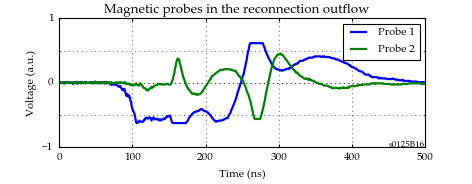

In [70]:
fig, ax=plt.subplots(figsize=(15/2.54, 2.3))

pair="C12"

a=ax
a.plot(b.bd[pair].time-1495, b.bd[pair].bd1_tr/1.1e8, lw=2, label="Probe 1")
a.plot(b.bd[pair].time-1495, b.bd[pair].bd2_tr/1.1e8, lw=2, label="Probe 2")
    
a.set_ylim([-1.0,1.0])
a.set_yticks([-1,0,1])

a.set_ylabel(r'Voltage (a.u.)', fontsize=10)

a.yaxis.set_minor_locator(MultipleLocator(0.5))

a.set_xlabel('Time (ns)', fontsize=10)

a.yaxis.set_label_coords(-0.06, 0.5)
a.grid(which='major')
a.grid(which='minor')
a.set_axisbelow(True)
a.legend(fontsize=10, )
a.tick_params(labelsize=10, pad=5, length=3, width=1)

a.set_xlim([0,500])
a.text(s='s0125B16', ha='right',x=500, y=-1, fontsize=8)

fig.suptitle('Magnetic probes in the reconnection outflow')

fig.subplots_adjust(bottom=0.2)

In [71]:
th_folder=r'~\Google Drive\MAGPIE\thesis\images'
fn='chapter5_s0125B16_C12_bdots.pdf'
p=os.path.expanduser(os.path.join(th_folder,fn))
fig.savefig(p, dpi=400)

### s0125B16 12 frame showing bdot disruption

In [86]:
cd "~\Google Drive\MAGPIE\data\2016\s0125B16 C RECONNECTION 12 FRAME + BDots\s0125B16 12 frame"

C:\Users\jdhare\Google Drive\MAGPIE\data\2016\s0125B16 C RECONNECTION 12 FRAME + BDots\s0125B16 12 frame


In [87]:
s=OpticalFrames(180,15)
s.logarithm()
s.rotate(-90+25.4)
s.crop((575,547), xcrop=230, ycrop=350)

C:\Users\jdhare\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


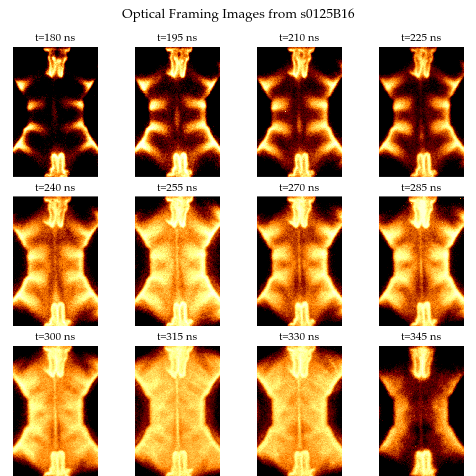

In [90]:
#151.3 mm = 5.96 inches

fig, ax=plt.subplots(3,4, figsize=(5.96,5.96),frameon = False)
plt.subplots_adjust(left=0, bottom=0, right=1, top=0.9,
                wspace=0.1, hspace=0.15)

for i in range(3):
    for j in range(4):
        fin=4*i+j
        ax[i,j].imshow(s.s_c[fin], cmap='afmhot', clim=[0.4,1.0], interpolation='none')
        ax[i,j].axis('off')
        ax[i,j].set_title('t='+str(s.frame_times[fin])+' ns', fontsize=10)
        
fig.suptitle('Optical Framing Images from s0125B16', fontsize=12)

In [91]:
th_folder=r'~\Google Drive\MAGPIE\thesis\images'
fn='chapter5_s0125B16_12frame.pdf'
p=os.path.expanduser(os.path.join(th_folder,fn))
fig.savefig(p, dpi=400)

### s0129_16

In [76]:
#T12 and T34 in reconnection flow, C12 in the divergent outflow
shot="s0129_16"
pairs={"C12":"A", "T12":"C", "T34":"D",}
attenuations={"A1":10.8,"A2":9.7, "C1":10, "C2":10, "D1":10, "D2":10}
diameters={"C12":2.0, "T12":0.5, "T34":0.5} #diameter in mm
b=Bdots(shot=shot, pairs=pairs, attenuations=attenuations, diameters=diameters, threshold=1.0)

<IPython.core.display.Javascript object>


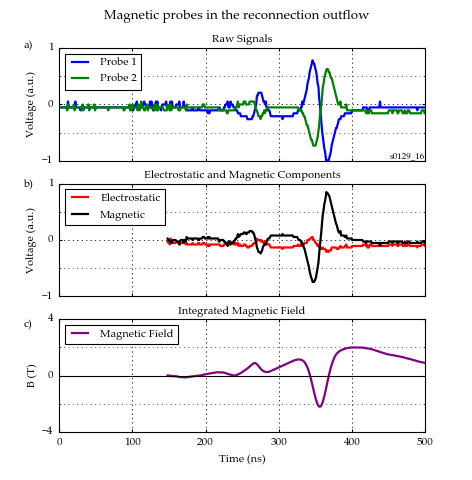

In [77]:
fig, ax=plt.subplots(3,1,figsize=(15/2.54, 6), sharex=True)

pair="T12"
ts=1530

a=ax[0]
a.plot(b.bd[pair].bd1.time-ts, b.bd[pair].bd1.data/6, lw=2, label="Probe 1")
a.plot(b.bd[pair].bd1.time-ts, b.bd[pair].bd2.data/6, lw=2, label="Probe 2")
    
a.set_ylim([-1.0,1.0])
a.set_yticks([-1,0,1])

a.set_ylabel(r'Voltage (a.u.)', fontsize=10)
a.set_title('Raw Signals', fontsize=10)

a.yaxis.set_minor_locator(MultipleLocator(0.5))

a=ax[1]

a.plot(b.bd[pair].time-ts, b.bd[pair].estat/3e8, lw=2, label="Electrostatic", c='r')
a.plot(b.bd[pair].time-ts, -b.bd[pair].dBdt/3e8, lw=2, label="Magnetic", c='k')
    
a.set_ylim([-1.0,1.0])
a.set_yticks([-1,0,1])

a.set_ylabel(r'Voltage (a.u.)', fontsize=10)
a.set_title('Electrostatic and Magnetic Components', fontsize=10)

a.yaxis.set_minor_locator(MultipleLocator(0.5))

a=ax[2]

a.plot(b.bd[pair].time_B-ts, -b.bd[pair].B, lw=2, label="Magnetic Field", c='purple')
a.plot([0,1000], [0,0], lw=1, c='black')
    
a.set_xlim([0,500])
a.set_ylim([-4,4])
a.set_yticks([-4,0,4])

a.set_ylabel(r'B (T)', fontsize=10)
a.set_title('Integrated Magnetic Field', fontsize=10)

a.yaxis.set_minor_locator(MultipleLocator(2))
a.xaxis.set_minor_locator(MultipleLocator(100))


a.set_xlabel('Time (ns)', fontsize=10)

for a in ax:
    a.yaxis.set_label_coords(-0.06, 0.5)
    a.grid(which='major')
    a.grid(which='minor')
    a.set_axisbelow(True)
    a.legend(fontsize=10, loc=2)
    a.tick_params(labelsize=10, pad=5, length=3, width=1)

    

fig.text(s='a)', x=0.05, y=0.9, fontsize=10)
fig.text(s='b)', x=0.05, y=0.61, fontsize=10)
fig.text(s='c)', x=0.05, y=0.32, fontsize=10)

ax[0].text(s='s0129_16', ha='right',x=500, y=-0.95, fontsize=8)

fig.suptitle('Magnetic probes in the reconnection outflow')

In [78]:
th_folder=r'~\Google Drive\MAGPIE\thesis\images'
fn='chapter5_s0129_16_bdots_reconnection_outflow.pdf'
p=os.path.expanduser(os.path.join(th_folder,fn))
fig.savefig(p, dpi=400)

### 12 frame of bdots

In [92]:
cd "~\Google Drive\MAGPIE\data\2016\s0129_16 RECONNECTION 12 fr + Bdots +Fday cup\s0129_16 12 Frame"

C:\Users\jdhare\Google Drive\MAGPIE\data\2016\s0129_16 RECONNECTION 12 fr + Bdots +Fday cup\s0129_16 12 Frame


In [93]:
s=OpticalFrames(145,15)
s.logarithm()
s.rotate(-90+25.4)
s.crop((575,550), xcrop=230, ycrop=350)

C:\Users\jdhare\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


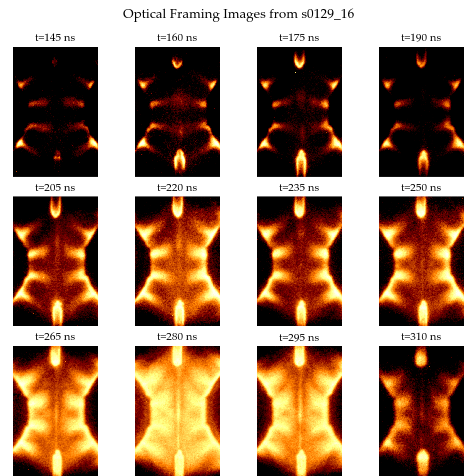

In [94]:
#151.3 mm = 5.96 inches

fig, ax=plt.subplots(3,4, figsize=(5.96,5.96),frameon = False)
plt.subplots_adjust(left=0, bottom=0, right=1, top=0.9,
                wspace=0.1, hspace=0.15)

for i in range(3):
    for j in range(4):
        fin=4*i+j
        ax[i,j].imshow(s.s_c[fin], cmap='afmhot', clim=[0.2,1.0], interpolation='none')
        ax[i,j].axis('off')
        ax[i,j].set_title('t='+str(s.frame_times[fin])+' ns', fontsize=10)
        
fig.suptitle('Optical Framing Images from s0129_16', fontsize=12)

In [95]:
th_folder=r'~\Google Drive\MAGPIE\thesis\images'
fn='chapter5_s0129_16_12frame.pdf'
p=os.path.expanduser(os.path.join(th_folder,fn))
fig.savefig(p, dpi=400)

## Faraday Rotation

### Raw data for s0513_16

In [83]:
cd "~\Google Drive\MAGPIE\data\2015\s0513_15 RECONNECTION - Carbon repeat"

C:\Users\jdhare\Google Drive\MAGPIE\data\2015\s0513_15 RECONNECTION - Carbon repeat


In [84]:
if_bk=rotate(plt.imread("s0513_15 IR side on interferometry t255ns.JPG"),4)
if_sh=rotate(plt.imread("s0513_15 IR side on interferometry (1).JPG"),4)
far_bk1=plt.imread("s0513_15/13-May-2015 16_19_03_1355463638.png")
far_bk2=plt.imread("s0513_15/13-May-2015 16_19_03_2211629970.png")
far_sh1=np.fliplr(plt.imread("s0513_15/13-May-2015 17_00_09_1355463638_fliplr.png"))
far_sh2=plt.imread("s0513_15/13-May-2015 17_00_09_2211629970.png")

C:\Users\jdhare\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


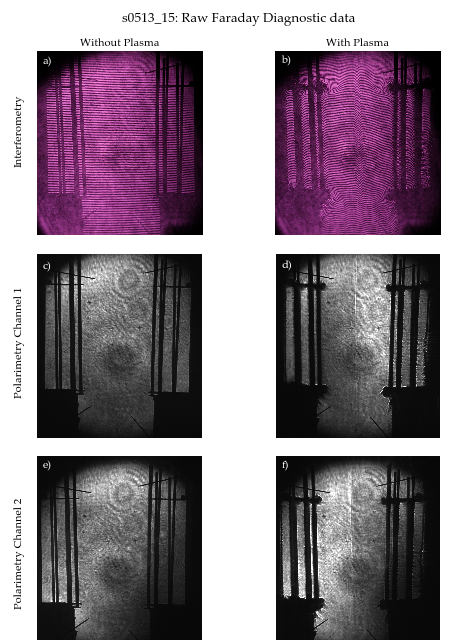

In [85]:
fig, ax=plt.subplots(3,2, figsize=(5.96,8), frameon=False)
a=ax[0,0]
a.imshow(np.rot90(if_bk[400:3300,1200:3800],2))
a.set_title("Without Plasma", fontsize=10)
a=ax[0,1]
a.imshow(np.rot90(if_sh[400:3300,1200:3800],2))
a.set_title("With Plasma", fontsize=10)

a=ax[1,0]
a.imshow(np.flipud(far_bk1[300:2100,900:2500]), cmap='gray', clim=[0,0.2])

a=ax[1,1]
a.imshow(np.flipud(far_sh1[300:2100,900:2500]), cmap='gray', clim=[0,0.2])

a=ax[2,0]
a.imshow(np.flipud(far_bk2[400:2200,900:2500]), cmap='gray', clim=[0,0.2])

a=ax[2,1]
a.imshow(np.flipud(far_sh2[400:2200,900:2500]), cmap='gray', clim=[0,0.2])


plt.subplots_adjust(left=0, bottom=0, right=1, top=0.92,
                wspace=0.0, hspace=0.1)

fig.suptitle("s0513_15: Raw Faraday Diagnostic data", fontsize=12)

for a in ax.flat:
    a.axis('off')
    
fig.text(0.03, 0.84,"Interferometry", fontsize=10,rotation='vertical')
fig.text(0.03, 0.54,"Polarimetry Channel 1", fontsize=10,rotation='vertical')
fig.text(0.03, 0.21,"Polarimetry Channel 2", fontsize=10,rotation='vertical')

fig.text(0.09, 0.9,"a)", fontsize=10, color='white')
fig.text(0.59, 0.9,"b)", fontsize=10, color='white')
fig.text(0.09, 0.58,"c)", fontsize=10, color='white')
fig.text(0.59, 0.58,"d)", fontsize=10, color='white')
fig.text(0.09, 0.27,"e)", fontsize=10, color='white')
fig.text(0.59, 0.27,"f)", fontsize=10, color='white')

In [267]:
th_folder=r'~\Google Drive\MAGPIE\thesis\images'
fn='chapter5_s0513_15_raw_faraday.pdf'
p=os.path.expanduser(os.path.join(th_folder,fn))
fig.savefig(p, dpi=400)

### Processed Faraday for s0513_15

In [2]:
cd "~\Google Drive\MAGPIE\data\2015\s0513_15 RECONNECTION - Carbon repeat\s0513_15"

C:\Users\jdhare\Google Drive\MAGPIE\data\2015\s0513_15 RECONNECTION - Carbon repeat\s0513_15


In [3]:
B0fn="13-May-2015 16_39_56_1355463638_fliplr.png"
B1fn="13-May-2015 16_39_56_2211629970.png"
S0fn="13-May-2015 17_00_09_1355463638_fliplr.png"
S1fn="13-May-2015 17_00_09_2211629970.png"
s0513_15_pol=PolarimetryMap2(B0fn, B1fn, B0fn, B1fn, S0fn, S1fn)
s=s0513_15_pol

In [4]:
t=pickle.load(open( "s0513_16 faraday registration.txt", "rb" ))

In [5]:
s.register(transform=t)

C:\Users\jdhare\Anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:568: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


In [6]:
s.convert_to_alpha()
s.scale=67
s.set_origin([1255,1682], extent=[-13,13,-6,6])
#s.plot_data_mm(clim=[-1,1])

In [7]:
cd "~\Google Drive\MAGPIE\data\2015\s0513_15 RECONNECTION - Carbon repeat"

C:\Users\jdhare\Google Drive\MAGPIE\data\2015\s0513_15 RECONNECTION - Carbon repeat


In [8]:
s0513_15_far=FaradayMap2(s0513_15_pol,"s0513_15 IR side on image registration flipud.jpg", "s0513_15 neL side on.txt")

C:\Users\jdhare\Documents\GitHub\magpie-analysis\magpie_data.py:200: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  I0zc=I0z[:,crop:-crop]
C:\Users\jdhare\Documents\GitHub\magpie-analysis\magpie_data.py:204: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.I1zc=I1z[:,crop:-crop]


In [9]:
f=s0513_15_far
t=pickle.load(open('s0513_15 interferometry transform.txt', 'rb'))

In [10]:
f.register(transform=t)

C:\Users\jdhare\Anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:568: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\jdhare\Documents\GitHub\magpie-analysis\magpie_data.py:214: RuntimeWarning: divide by zero encountered in true_divide
  self.data=5.99e18*self.pm.data/self.I1T
C:\Users\jdhare\Documents\GitHub\magpie-analysis\magpie_data.py:214: RuntimeWarning: overflow encountered in true_divide
  self.data=5.99e18*self.pm.data/self.I1T
C:\Users\jdhare\Documents\GitHub\magpie-analysis\magpie_data.py:214: RuntimeWarning: invalid value encountered in true_divide
  self.data=5.99e18*self.pm.data/self.I1T


In [11]:
f.scale=s.scale
f.set_origin(s.origin, extent=[-13,13,-6,6])

In [12]:
#create a trojan horse that we can slip our real data inside
s0513_15_ne=NeLMap2('s0513_15 neL side on.txt', scale=s.scale) 

In [13]:
ne=s0513_15_ne
ne.data=f.I1T
ne.scale=s.scale
ne.set_origin(origin=s.origin, extent=[-13,13,-6,6])

In [14]:
b_map=f.data_c.copy()
b_map[b_map>100]=0
b_map[b_map<-100]=0

In [15]:
ne.data_c.max()

2.5151901774306811e+18

<IPython.core.display.Javascript object>


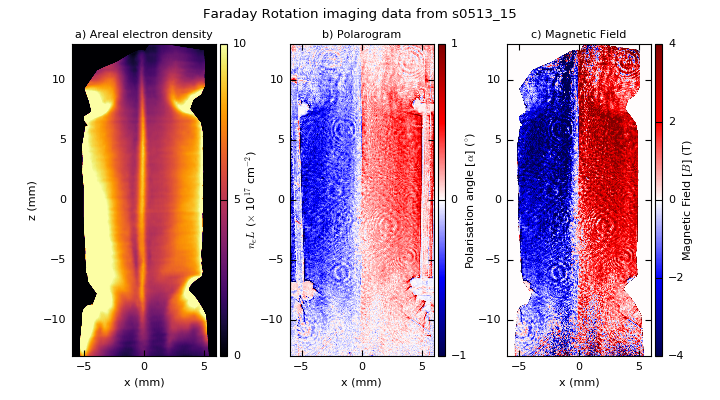

In [16]:
fig, ax=plt.subplots(1,3, figsize=(9,5))
ne_im=ax[0].imshow(np.flipud(ne.data_c/1e17), extent=s.extent, clim=[0,10], cmap=cmaps.cmaps['inferno'], aspect=1)
pol_im=ax[1].imshow(np.flipud(s.data_c), extent=s.extent, clim=[-1,1], cmap='seismic')

mag_im=ax[2].imshow(np.flipud(b_map), extent=f.extent, clim=[-4,4], cmap='seismic')
#f.plot_data_mm(ax=ax[2], clim=[-4,4])

#labels and ticks
for a in ax:
    a.set_xlabel('x (mm)',fontsize=10)
    a.set_xticks([-5,0,5])
    a.tick_params(labelsize=10, pad=5, length=5, width=1)
ax[0].set_ylabel('z (mm)',fontsize=10)
ax[0].set_title('a) Areal electron density', fontsize=10)
ax[1].set_title('b) Polarogram', fontsize=10)
ax[2].set_title('c) Magnetic Field', fontsize=10)

#set up the colourbar
divider0 = make_axes_locatable(ax[0])
cbar_ax0 = divider0.append_axes("right", size="5%", pad=0.05)
c=cbar_ax0
fig.colorbar(ne_im, cax=c, ticks=[0,5,10])
c.set_ylabel(r'$n_e L$ ($\times$ 10$^{17}$ cm$^{-2}$)',fontsize=10, labelpad=-3)


divider1 = make_axes_locatable(ax[1])
cbar_ax1 = divider1.append_axes("right", size="5%", pad=0.05)
c=cbar_ax1
fig.colorbar(pol_im, cax=c, ticks=[-1,0,1])
c.set_ylabel(r'Polarisation angle [$\alpha$] ($^{\circ}$)',fontsize=10, labelpad=-3)

divider2 = make_axes_locatable(ax[2])
cbar_ax2 = divider2.append_axes("right", size="5%", pad=0.05)
c=cbar_ax2
fig.colorbar(mag_im, cax=c, ticks=[-4, -2,0,2,4])
c.set_ylabel(r'Magnetic Field [$B$] (T)',fontsize=10, labelpad=-3)


plt.subplots_adjust(left=0.1, bottom=0.1, right=0.92, top=0.9,
                wspace=0.4, hspace=0.1)

#colour bars
for c in [cbar_ax0,cbar_ax1,cbar_ax2]:
    c.tick_params(labelsize=10, pad=5, length=6, width=1)
    
fig.suptitle("Faraday Rotation imaging data from s0513_15", fontsize=12)

In [17]:
th_folder=r'~\Google Drive\MAGPIE\thesis\images'
fn='chapter5_s0513_15_faraday_data.pdf'
p=os.path.expanduser(os.path.join(th_folder,fn))
fig.savefig(p, dpi=400)

<IPython.core.display.Javascript object>


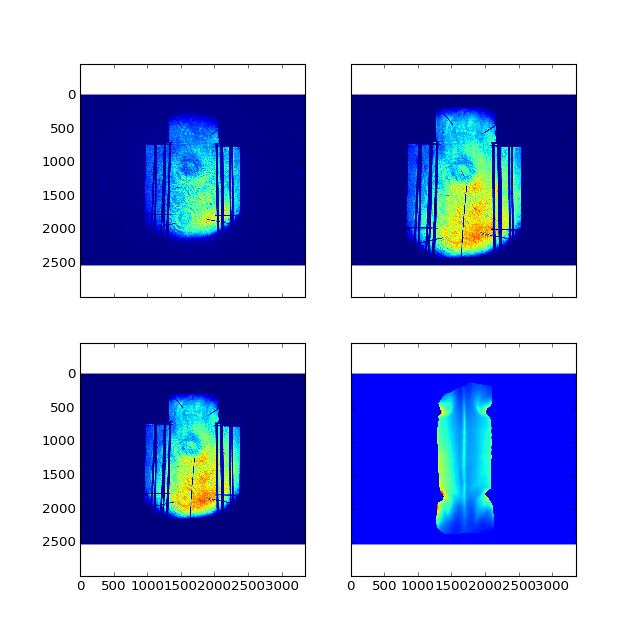

In [17]:
fig, ax=plt.subplots(2,2,figsize=(8,8),sharex=True, sharey=True)
ax[0,1].imshow(f.I0zcn)
ax[0,0].imshow(f.pm.B0)
ax[1,0].imshow(f.I0T)
ax[1,1].imshow(np.flipud(f.I1zc))

## Lineouts from s0513_15 Faraday

(871, 134) (871, 670)
(871, 134) (871, 670)


<IPython.core.display.Javascript object>


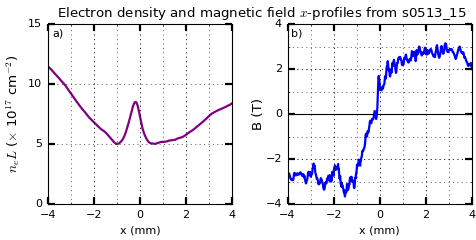

In [35]:
xx=4
zz=0 #note the the data files are flipped ud wrt to the images, so think about the sign here!
lw=2*s.scale

f.create_lineout(start=(zz,-xx), end=(zz, xx), lineout_width=lw)
ne.create_lineout(start=(zz,-xx), end=(zz, xx), lineout_width=lw)


fig, ax=plt.subplots(1,2, figsize=(5.96,3), sharex=True)

ax[0].plot(ne.mm, ne.lo/1e17, lw=2, c='purple')
ax[1].plot([-10,10],[0,0], c='black')
ax[1].plot(f.mm, f.lo, lw=2, c='blue')

for a in ax:
    a.tick_params(labelsize=10, pad=5, length=6, width=2)
    a.grid(True)
    a.set_xlabel("x (mm)", fontsize=10)
    a.set_xlim([-4,4])
    a.set_xticks([-4,-2,0,2,4])
    a.xaxis.set_minor_locator(MultipleLocator(1))
    a.grid(which='minor')

    
ax[0].set_ylabel(r'$n_e L$ ($\times$ 10$^{17}$ cm$^{-2}$)')
ax[0].set_yticks([0,5,10, 15])
ax[1].set_ylabel(r'B (T)', labelpad=0)
ax[1].set_yticks([-4,-2,0,2,4])
ax[1].set_ylim([-4,4])

ax[1].yaxis.set_minor_locator(MultipleLocator(1))

fig.subplots_adjust(left=0.1, bottom=0.15, right=0.99, top=0.9,
                wspace=0.3, hspace=0.1)

fig.suptitle(r'Electron density and magnetic field $x$-profiles from s0513_15', fontsize=12, x=0.55)

fig.text(0.11, 0.85,"a)", fontsize=10)
fig.text(0.61, 0.85,"b)", fontsize=10)

In [36]:
th_folder=r'~\Google Drive\MAGPIE\thesis\images'
fn='chapter5_s0513_15_faraday_horizontal_lineouts.pdf'
p=os.path.expanduser(os.path.join(th_folder,fn))
fig.savefig(p, dpi=400)

(469, 201) (1273, 201)
(469, 201) (1273, 201)


<IPython.core.display.Javascript object>


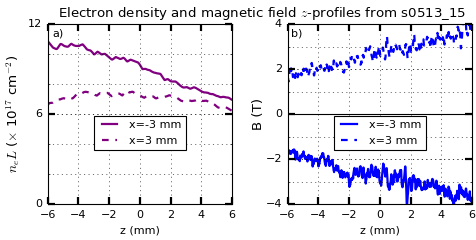

(469, 603) (1273, 603)
(469, 603) (1273, 603)


In [37]:
xx=-3
zz=6
lw=1*s.scale

f.create_lineout(start=(zz,xx), end=(-zz, xx), lineout_width=lw)
ne.create_lineout(start=(zz,xx), end=(-zz, xx), lineout_width=lw)

fig, ax=plt.subplots(1,2, figsize=(5.96,3), sharex=True)

ax[0].plot(ne.mm, ne.lo/1e17, lw=2, c='purple', label='x='+str(xx)+' mm')
ax[1].plot([-10,10],[0,0], c='black')
ax[1].plot(f.mm, f.lo, lw=2, c='blue',label='x='+str(xx)+' mm')

xx=3

f.create_lineout(start=(zz,xx), end=(-zz, xx), lineout_width=lw)
ne.create_lineout(start=(zz,xx), end=(-zz, xx), lineout_width=lw)

ax[0].plot(ne.mm, ne.lo/1e17, lw=2, c='purple', label='x='+str(xx)+' mm', ls='--')
ax[1].plot(f.mm, f.lo, lw=2, c='blue',label='x='+str(xx)+' mm', ls='--')


for a in ax:
    a.tick_params(labelsize=10, pad=5, length=6, width=2)
    a.grid(True)
    a.set_xlabel("z (mm)", fontsize=10)
    a.set_xlim([-6,6])
    a.set_xticks([-6,-4,-2,0,2,4,6])
    
ax[0].set_ylabel(r'$n_e L$ ($\times$ 10$^{17}$ cm$^{-2}$)')
ax[0].set_yticks([0,6,12])
ax[1].set_ylabel(r'B (T)', labelpad=0)
ax[1].set_yticks([-4,-2,0,2,4])
ax[1].set_ylim([-4,4])

ax[0].yaxis.set_minor_locator(MultipleLocator(2))
ax[0].grid(which='minor')


ax[1].yaxis.set_minor_locator(MultipleLocator(1))
ax[1].grid(which='minor')

ax[0].legend(fontsize=10, loc=(0.25,0.3))
ax[1].legend(fontsize=10, loc=(0.25,0.3))


fig.subplots_adjust(left=0.1, bottom=0.15, right=0.99, top=0.9,
                wspace=0.3, hspace=0.1)

fig.suptitle('Electron density and magnetic field $z$-profiles from s0513_15', fontsize=12, x=0.55)


fig.text(0.11, 0.85,"a)", fontsize=10)
fig.text(0.61, 0.85,"b)", fontsize=10)

In [38]:
th_folder=r'~\Google Drive\MAGPIE\thesis\images'
fn='chapter5_s0513_15_faraday_vertical_lineouts.pdf'
p=os.path.expanduser(os.path.join(th_folder,fn))
fig.savefig(p, dpi=400)